# Projecting Food Insecurity Rates in the US by County
## Feature Selection & Modeling Process
### Flatiron School Data Science Capstone<br>By Khyatee Desai

This notebook contains the feature selection and modeling process to predict food insecurity rates based on a number of features, both from the original datasets, as well as engineered features which were created in [feature_engineering.ipynb](feature_engineering.ipynb).

In [613]:
import pandas as pd
import numpy as np
import geopandas as gpd
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statistics as stats
import scipy.stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import sklearn
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
import pickle
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
warnings.filterwarnings('ignore')
import sys
sys.path.insert(0, '../src/')
from functions import *

### Import cleaned dataset

In [663]:
with open('../pickled/feature_engineered_data.pickle', "rb") as input_file:
    df = pickle.load(input_file) 
    
# remove features not needed for modeling
df.drop([ 'coc_number','Low Threshold Type', 'High Threshold Type',
       'State', 'County', 'State/County'],axis=1, inplace=True)
df.head(3)

,FIPS,Rent,Year,Houseless_rate,Sheltered_rate,Unsheltered_rate,hh_med_income,percent_hh_poverty,hh_avg_size,num_hh,TOT_POP,FI Rate,Cost Per Meal,Num_wholesale,Num_restaraunts,Num_grocery,Total_workforce,Employed,Unemployed,Unemployment_rate,Percent_male,Percent_female,Percent_white,Percent_Black,Percent_native,Percent_asian,Percent_pacific,Percent_latinX,Percent_PoC,Percent_working,Total_food_retail,Food_retail_per_person,Percent_disabled,Percent_hs_grad,Percent_bachelors,Percent_grad_degree,Percent_priv_health,Percent_public_health,Percent_no_health,Percent_65+,Percent_non_citizen,Percent_hh_no_vehicle,Percent_hh_SNAP,Unemployment_rate_X_Percent_Black,Unemployment_rate_X_Percent_white,Unemployment_rate_X_Percent_latinX,Houseless_rate_X_Sheltered_rate,Sheltered_rate_X_Percent_grad_degree,Percent_Black_X_Percent_hh_SNAP,Percent_latinX_X_hh_med_income,Cost Per Meal_X_Percent_Black,Unemployment_rate_X_hh_avg_size,Percent_white_X_Percent_hh_SNAP,Rent_X_Unemployment_rate,Percent_Black_X_Percent_grad_degree,Percent_pacific_X_Percent_hs_grad,Percent_latinX_X_Percent_hh_SNAP,Unemployment_rate_X_Percent_non_citizen,Percent_white_X_Percent_grad_degree,Percent_latinX_X_percent_hh_poverty,TOT_POP_X_Percent_latinX,Unemployment_rate_X_Percent_female,Unemployment_rate_X_Percent_male,Percent_pacific_X_Percent_public_health,Percent_Black_X_Percent_hs_grad,Percent_latinX_X_num_hh,Rent_X_Percent_Black,Num_grocery_X_num_hh,Houseless_rate_X_Percent_pacific,Percent_white_X_percent_hh_poverty,Percent_white_X_Percent_priv_health,Percent_white_X_Percent_pacific,Unemployment_rate_X_Percent_hs_grad,Unemployment_rate_X_Percent_disabled,Percent_white_X_Percent_no_health,Percent_female_X_Percent_hs_grad,Sheltered_rate_X_Percent_working,Percent_Black_X_Percent_no_health,Percent_Black_X_percent_hh_poverty,Percent_pacific_X_Percent_disabled,Cost Per Meal_X_Percent_white,Percent_pacific_X_Percent_65+,Sheltered_rate_X_Percent_no_health,TOT_POP_X_Num_grocery,Percent_Black_X_hh_med_income,Percent_Black_X_Percent_priv_health,Percent_hs_grad_X_hh_avg_size,Sheltered_rate_X_Percent_pacific,Unemployment_rate_X_Percent_hh_SNAP,Percent_latinX_X_Percent_priv_health,Total_food_retail_X_num_hh,Houseless_rate_X_Percent_grad_degree,Percent_pacific_X_Percent_hh_SNAP,log_Rent,log_Houseless_rate,log_Sheltered_rate,log_Unsheltered_rate,log_TOT_POP,log_Cost Per Meal,log_Num_wholesale,log_Num_restaraunts,log_Num_grocery,log_Unemployment_rate,log_Percent_male,log_Percent_female,log_Percent_white,log_Percent_Black,log_Percent_native,log_Percent_asian,log_Percent_pacific,log_Percent_latinX,log_Percent_working,log_Total_food_retail,log_Food_retail_per_person,log_Percent_disabled,log_Percent_hs_grad,log_Percent_bachelors,log_Percent_grad_degree,log_Percent_priv_health,log_Percent_public_health,log_Percent_no_health,log_Percent_65+,log_Percent_non_citizen,log_Percent_hh_no_vehicle,log_Percent_hh_SNAP,log_percent_hh_poverty,log_hh_avg_size,log_num_hh,log_hh_med_income,Lo_thresh_SNAP,Lo_thresh_SNAP_other,Hi_thresh_SNAP,Hi_thresh_SNAP_other,Hi_thresh_other
0,01073,1019.995960,2014,0.001396,0.000961,0.000435,45239.0,14.8,2.48,259397.0,659972.0,0.197,2.93,483.0,2693.0,400.0,312131.0,292505.0,19626.0,6.3,0.473491,0.526509,0.538864,0.430446,0.003074,0.015725,0.000526,0.036515,0.461136,0.472946,3576.0,0.005418,0.143315,0.178574,0.123681,0.079964,0.654025,0.320574,0.123242,0.131878,0.026545,0.360953,0.154077,2.711807,3.394842,0.230046,0.000001,0.000077,0.066322,1651.910477,1.261205,15.624,0.083026,6425.974545,0.034420,0.000094,0.005626,0.167234,0.043090,0.540425,24099.0,3.317005,2.982995,0.000169,0.076866,9471.929571,439.052706,103758800.0,7.338020e-07,7.975184,0.352430,0.000283,1.125018,0.902886,0.066410,0.094021,0.000454,0.053049,6.370594,0.000075,1.578871,0.000069,0.000118,263988800.0,19472.925515,0.281522,0.442864,5.052135e-07,0.970682,0.023882,927603672.0,0.000112,0.000081,6.927554,-6.574399,-6.947657,-7.740715,13.399953,1.075002,6.180017,7.898411,5.991465,1.840550,-0.747622,-0.641487,-0.61

# Linear Regression Models
## Model 1: All Features
The first model is a simple linear regression model that trains on data from years 2010-2019, uses *all* engineered features created in feature_engineering.ipynb.

### Train/Test Split
**Note:** The rent column is dropped for all models, because rent price data was only available for major metropolitan areas, and therefore retaining the column would require dropping a large majority of rows in order for the models to run. This decision should not significantly impact the performance of the models, given that the relationship between rent and the FI rates is not very strong, as was determined through the EDA process.

In [615]:
df.Year.value_counts()

2019    3518
2018    3406
2017    3395
2014    3386
2016    3386
        ... 
2010    3279
2009    3239
2011    1785
2012    1785
2013    1785
Name: Year, Length: 12, dtype: int64

In [616]:
# Limit the year and drop rows containing null values in either of the specified columns.
df_model = df[df.Year.isin(['2010','2011','2012','2013','2014','2015','2016','2017'
                ,'2018','2019'])].dropna(subset=['Num_wholesale','Houseless_rate','Percent_disabled','hh_med_income'])

# drop the Rent column, and all engineers features using the rent column
for col in df_model.columns:
    if 'Rent' in col:
        df_model.drop(col,axis=1,inplace=True)

# isolate target variable and features
y = df_model['FI Rate']
X = df_model.drop([ 'FIPS','FI Rate','Year'],axis=1)

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2)

In [617]:
df_model.shape

(13305, 130)

### Model 1
The model uses 19330 observations (seen above) and uses Cross Validation with 5 folds. It produces a Train/Test R-Squared value of about 0.65, an average Train/Test RMSE of 0.0258, and a mean cross validation score of 0.586.

In [618]:
# Instantiate Linear Regression model
linreg_1 = LinearRegression()
linreg_1.fit(X_train, y_train)
y_train_pred = linreg_1.predict(X_train)
y_test_pred = linreg_1.predict(X_test)

# R2 of training and test set
print('R2 Train:',linreg_1.score(X_train, y_train))
print('R2 Test:',linreg_1.score(X_test, y_test))

# RMSE of training and test set
print('RMSE Train:',np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('RMSE Test:',np.sqrt(mean_squared_error(y_test, y_test_pred)),'\n')

scores =cross_val_score(linreg_1, X, y, cv=5,  scoring='r2')
print('CV Scores:',scores)
print('Mean CV Score:',np.mean(scores))

R2 Train: 0.8920125042108359
R2 Test: 0.8805954830282634
RMSE Train: 0.014120472738269664
RMSE Test: 0.01449219889218035 

CV Scores: [0.85298764 0.87968246 0.81489992 0.7503781  0.90243984]
Mean CV Score: 0.840077590566762


## Linear Regression Model 2: Remove Outliers
The EDA notebook included a section on inspecting which features have the largest outliers, using box and whisker plots. The following cell focuses on the features with highest outliers: `'TOT_POP'`, `'num_hh'`, `'Total_workforce'`, `'Employed'`, `'hh_avg_size'`,`'Unemployed'`, `'Unemployment_rate_X_hh_avg_size'`,`'Total_workforce'`, and `'Total_food_retail'`

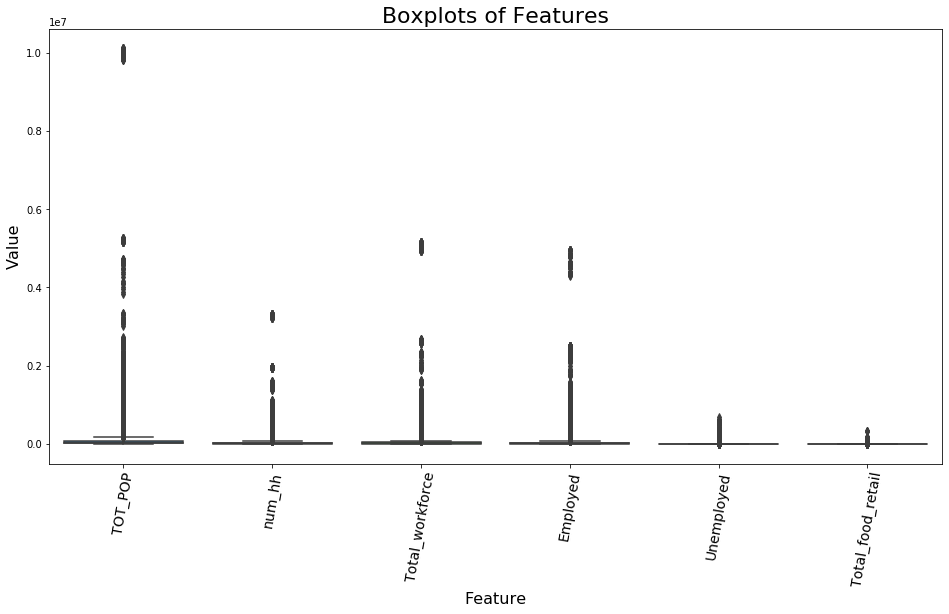

In [619]:
features = ['TOT_POP', 'num_hh', 'Total_workforce', 'Employed', 'Unemployed', 'Total_food_retail']

# create boxplot for each feature with outliers
plt.figure(figsize=(16, 8));
sns.boxplot(data= df.loc[:,features]);
plt.title('Boxplots of Features', fontdict={'fontsize':22});
plt.ylabel('Value', fontdict={'fontsize':16});
plt.xlabel('Feature', fontdict={'fontsize':16});
plt.xticks(rotation=80,fontsize=14);


### Remove Outliers
The following cell iterates over each feature with outliers, and if the feature has obsrvations *greater* than +/- 2 standard deviations of the mean, it reduces outliers to +/- 2 standard deviations from the mean of that feature.

In [620]:
# Bring outliers down/up to 2 standard deviations from the mean 
df_out = df.copy()
for feat in features:
    abv_2_std = df_out[feat].mean()+ 2* df_out[feat].std()
    below_2_std = df_out[feat].mean()- 2* df_out[feat].std()
    conditions = [df_out[feat]>abv_2_std, df_out[feat]<below_2_std]
    choices = [abv_2_std, below_2_std]
    df_out[feat] = np.select(conditions, choices, df_out[feat])


### Visualize Again
After reducing outliers, the boxplots are visualized again:

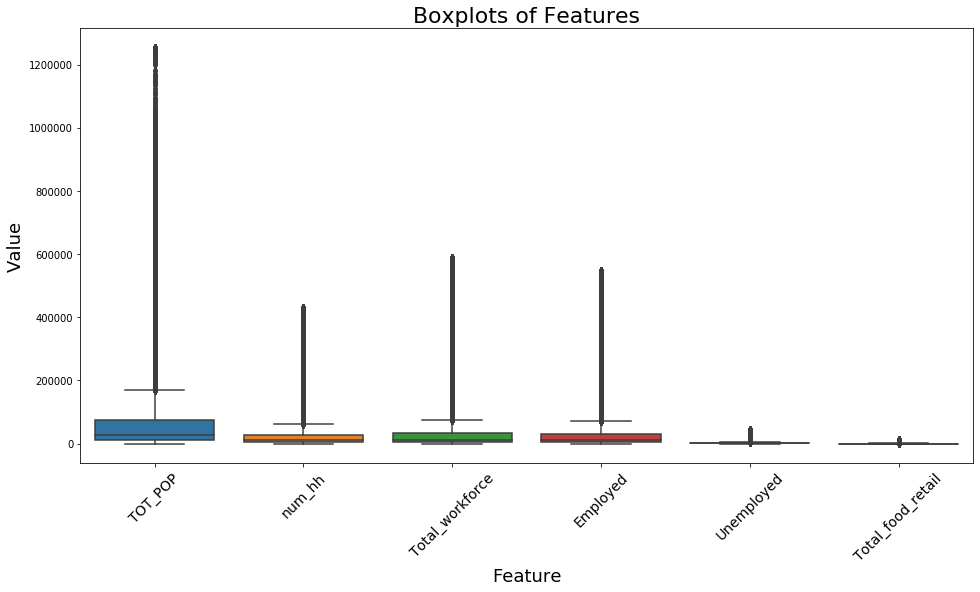

In [621]:
# create boxplot for each feature with outliers
plt.figure(figsize=(16, 8));
sns.boxplot(data= df_out[features]);
plt.title('Boxplots of Features', fontdict={'fontsize':22});
plt.ylabel('Value', fontdict={'fontsize':18});
plt.xlabel('Feature', fontdict={'fontsize':18});
plt.xticks(rotation=45,fontsize=14);

### Train/Test Split 2
Perform train/test split similarly as above, after massive outliers have been reduced

In [622]:
# Limit the year and drop null values
df_model = df_out[df_out.Year.isin(['2010','2011','2012','2013','2014','2015','2016','2017'
                 ,'2018'])].dropna(subset=['Num_wholesale','Percent_disabled','Houseless_rate','hh_med_income'])
for col in df_model.columns:
    if 'Rent' in col:
        df_model.drop(col,axis=1,inplace=True)
        
# isolate target variable and features
y = df_model['FI Rate']
X = df_model.drop(['FIPS', 'FI Rate','Year'],axis=1)

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Model 2
Re-run the model using the same process as model 1, now on data with reduced outliers.<br>
Model 2 produces a slightly better Train/Test R-Squared value of about 0.76, a worse average Train/Test RMSE of about 0.0214, and a much lower mean cross validation score of 0.503.<br>**For this reason, outliers are retained in the following models.**

In [623]:
# Instantiate Linear Regression model
linreg_2 = LinearRegression()
linreg_2.fit(X_train, y_train)
y_train_pred = linreg_2.predict(X_train)
y_test_pred = linreg_2.predict(X_test)

# R2 of training and test set
print('R2 Train:',linreg_2.score(X_train, y_train))
print('R2 Test:',linreg_2.score(X_test, y_test))

# RMSE of training and test set
print('RMSE Train:',np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('RMSE Test:',np.sqrt(mean_squared_error(y_test, y_test_pred)))

scores =cross_val_score(linreg_2, X, y, cv=5,  scoring='r2')
print('CV Scores:',scores)
print('Mean CV Score:',np.mean(scores))

R2 Train: 0.8913438032740331
R2 Test: 0.8873380353322973
RMSE Train: 0.014085869741742033
RMSE Test: 0.014389201821415768
CV Scores: [0.88467023 0.8801926  0.79756657 0.75196863 0.90199649]
Mean CV Score: 0.8432789027233042


# Feature Selection
The following processes use a few different feature selection methods to determine the optimal features for the MVP model
### Train/Test Split 3 
Need to do this again to add outliers back in

In [624]:
# create df_model again, with outliers included this time
df_model = df[df.Year.isin(['2010','2011','2012','2013','2014','2015','2016','2017','2018',
                    '2019'])].dropna(subset=['Num_wholesale','Percent_disabled','Houseless_rate','hh_med_income'])
for col in df_model.columns:
    if 'Rent' in col:
        df_model.drop(col,axis=1,inplace=True)
        
# isolate target variable and features
y = df_model['FI Rate']
X = df_model.drop(['FIPS', 'FI Rate','Year'],axis=1)

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Multicollinearity 
Multicollinearity can create noise within the data. A heatmap is produced from correlation matrix in the [EDA.ipynb](EDA.ipynb) notebook, which highlights that houseless rate, sheltered/unsheltered rates, and all of the race-related features are highly correlated with one another. The following cells explain the correlation between feature pairs even more:
### Inspect correlation between each feature pair
The correlation matrix is reformatted to show the correlation between each feature pair - we see that demographics features, employment-related features, and houselessness-related features are all highly correlated, which is to be expected.

In [625]:
# reformat the correlation matrix and output top 15 pairs
corr=df_model.iloc[:,1:].corr().abs().stack().reset_index().sort_values(0, ascending=False)
corr['pairs'] = list(zip(corr.level_0, corr.level_1))
corr.drop(columns=['level_1', 'level_0'], inplace = True)
corr.columns = ['correlation', 'pairs']
corr.drop_duplicates(inplace=True)
corr[(corr.correlation >0.95) & (corr.correlation <1.0)][:15]

,correlation,pairs
7952,0.999764,"(Num_grocery_X_num_hh, TOT_POP_X_Num_grocery)"
9968,0.999764,"(TOT_POP_X_Num_grocery, Num_grocery_X_num_hh)"
1665,0.999674,"(Total_workforce, Employed)"
1791,0.999674,"(Employed, Total_workforce)"
902,0.999181,"(TOT_POP, Total_workforce)"
...,...,...
12337,0.998215,"(log_Percent_male, Percent_female)"
2383,0.998215,"(Percent_female, log_Percent_male)"
2256,0.998215,"(Percent_male, log_Percent_male)"
12336,0.998215,"(log_Percent_male, Percent_male)"


### Varience Inflation Factor
Variance inflation factor (VIF) helps quantifies the severity of multicollinearity in a regression model, by comparing variance of the model with different terms. High VIF scores indicate severe multicollinearity. The following cell creates a dataframe only with features that have VIF scores below 40:

In [626]:
# create a vif dataframe with all features of scores below 40
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["features"] = X_train.columns
vif_features = vif[vif['VIF Factor'] <40]['features']
vif[vif['VIF Factor'] <40].head()

,VIF Factor,features
21,36.326260,Percent_asian
27,3.607270,Food_retail_per_person
30,39.078320,Percent_bachelors
36,26.243234,Percent_non_citizen
37,16.528137,Percent_hh_no_vehicle


## Linear Regression Model 3: Removed Multicollinear Features
Model 3 uses only features with VIF scores below 40. It performs significantly worse than the prior models, with a Train/Test R-Squared value of about 0.46, a Train/Test RMSE of about 0.031, and a much lower mean cross validation score of 0.40.


In [627]:
# Instantiate Linear Regression model
linreg_3 = LinearRegression()
linreg_3.fit(X_train[vif_features], y_train)
y_train_pred = linreg_3.predict(X_train[vif_features])
y_test_pred = linreg_3.predict(X_test[vif_features])

# R2 of training and test set
print('R2 Train:',linreg_3.score(X_train[vif_features], y_train))
print('R2 Test:',linreg_3.score(X_test[vif_features], y_test))

# RMSE of training and test set
print('RMSE Train:',np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('RMSE Test:',np.sqrt(mean_squared_error(y_test, y_test_pred)))

scores =cross_val_score(linreg_3, X[vif_features], y, cv=5,  scoring='r2')
print('CV Scores:',scores)
print('Mean CV Score:',np.mean(scores))

R2 Train: 0.7710423318072955
R2 Test: 0.7685274362003313
RMSE Train: 0.02065634972465355
RMSE Test: 0.019983883655496932
CV Scores: [0.78330983 0.75665493 0.70416894 0.6497418  0.77611275]
Mean CV Score: 0.7339976501461294


## Linear Regression 4: K-Best Selected Features
Model 4 uses `SelectKBest()` to determine the best k featues to use in a model. The cell below loops through a number of k values to determine the optimal one.

In [628]:
# determine optimal k with a loop 

for k in range(75,85):
    selector = SelectKBest(f_regression, k=k)
    selector.fit(X_train, y_train)
    kbest_features = X_train.columns[selector.get_support()]
    linreg = LinearRegression()
    linreg.fit(X_train[kbest_features], y_train)
    y_test_pred = linreg.predict(X_test[kbest_features])
    print(k,'\n', linreg.score(X_test[kbest_features],y_test))
    print(np.mean(cross_val_score(linreg, X[kbest_features], y, cv=5,  scoring='r2')))


75 
 0.8813508126489923
0.8469080418523915
76 
 0.8813040761291957
0.8470042599553859
77 
 0.8814086949517834
0.8471156107484301
78 
 0.881408694951421
0.8471156107467623
79 
 0.8815328666682769
0.847407801226
80 
 0.8816674888334455
0.8462864475737082
81 
 0.8816306640018294
0.8461808229678797
82 
 0.8817227166787086
0.846432910736819
83 
 0.8816856382423669
0.8465839042130867
84 
 0.8816901893467141
0.8466566370647982


### Model 4
The best k value is determined to be 115, so model 4 is run with those features. Model 4 performs significantly better than others, with an average **R-squared value of .79**, an **RMSE of .0199**, and an average **cross validation score of 0.743.**

In [629]:
# run model with best k features
selector = SelectKBest(f_regression, k=76)
selector.fit(X_train, y_train)
kbest_features = X_train.columns[selector.get_support()]

linreg_4 = LinearRegression()
linreg_4.fit(X_train[kbest_features], y_train)
y_train_pred = linreg_4.predict(X_train[kbest_features])
y_test_pred = linreg_4.predict(X_test[kbest_features])

# R2 of training and test set
print('R2 Train:', linreg_4.score(X_train[kbest_features], y_train))
print('R2 Test:', linreg_4.score(X_test[kbest_features], y_test))

# RMSE of training and test set
print('RMSE Train:',np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('RMSE Test:',np.sqrt(mean_squared_error(y_test, y_test_pred)))

# cross validation scores
scores = cross_val_score(linreg_4, X[kbest_features], y, cv=5,  scoring='r2')
print('CV Scores:',scores)
print('Mean CV Score:',np.mean(scores))

R2 Train: 0.8855918598942403
R2 Test: 0.8813040761291957
RMSE Train: 0.014601734379074478
RMSE Test: 0.01431027679743359
CV Scores: [0.89334031 0.87582829 0.81642425 0.75107702 0.89835143]
Mean CV Score: 0.8470042599553859


## Linear Regression Model 5: Recursive Feature Elimination
Recursive feature elimination is used to iteratively remove features and rerun the model, in order to find an optimal set of features to use.
### Run RFE to retrieve set of rfe_features

In [630]:
linreg = LinearRegression()
selector = RFECV(estimator= linreg, step=1, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
selector.fit(X_train, y_train)
rfe_features = X_train.columns[selector.support_]

### Linear Regression Model 5:
The RFE model performs approximately as well as the Select K Best model, with an average **R-squared value of .79**, an **RMSE of .0198**, and an average **cross validation score of 0.749**.

In [631]:
linreg_5 = LinearRegression()
linreg_5.fit(X_train[rfe_features], y_train)
y_train_pred = linreg_5.predict(X_train[rfe_features])
y_test_pred = linreg_5.predict(X_test[rfe_features])

# R2 of training and test set
print('R2 Train:',linreg_5.score(X_train[rfe_features], y_train))
print('R2 Test:',linreg_5.score(X_test[rfe_features], y_test))

# RMSE of training and test set
print('RMSE Train:',np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('RMSE Test:',np.sqrt(mean_squared_error(y_test, y_test_pred)),'\n')

# cross validation scores
scores = cross_val_score(linreg_5, X[rfe_features], y, cv=5,  scoring='neg_root_mean_squared_error')
print('CV Scores:',scores)
print('Mean CV Score:', abs(np.mean(scores)))

R2 Train: 0.8904993826820988
R2 Test: 0.8889540375085156
RMSE Train: 0.014285132235350969
RMSE Test: 0.013841447761140347 

CV Scores: [-0.01534435 -0.01532169 -0.01676492 -0.01960091 -0.01338161]
Mean CV Score: 0.01608269511369346


# Neural Network Regressor

In [632]:
# create df_model again, with outliers included this time
df_model = df[df.Year.isin(['2010','2011','2012','2013','2014','2015','2016','2017','2018',
                    '2019'])].dropna(subset=['Num_wholesale','Percent_disabled','Houseless_rate','hh_med_income'])
for col in df_model.columns:
    if 'Rent' in col:
        df_model.drop(col,axis=1,inplace=True)
        
# isolate target variable and features
y = df_model['FI Rate']
X = df_model.drop(['FIPS', 'FI Rate','Year'],axis=1)

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [633]:
from keras.losses import mean_squared_error
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras import backend as K

In [634]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(X[rfe_features].shape[1], kernel_initializer='normal',input_dim = X[rfe_features].shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(80, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(80, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(mean_squared_error(y_true, y_pred))
              
# Compile the network :
NN_model.compile(loss= root_mean_squared_error, optimizer='RMSprop',metrics=[root_mean_squared_error])
NN_model.summary()

Model: "sequential_116"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_346 (Dense)            (None, 120)               14520     
_________________________________________________________________
dense_347 (Dense)            (None, 80)                9680      
_________________________________________________________________
dense_348 (Dense)            (None, 80)                6480      
_________________________________________________________________
dense_349 (Dense)            (None, 1)                 81        
Total params: 30,761
Trainable params: 30,761
Non-trainable params: 0
_________________________________________________________________


In [635]:
# checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
# checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
# callbacks_list = [checkpoint]

In [636]:
NN_model.fit(X[rfe_features], y, epochs=5, batch_size=10, validation_split = 0.2)


Epoch 1/5
1065/1065 [==============================] - 4s 2ms/step - loss: 39.4824 - root_mean_squared_error: 39.4824 - val_loss: 0.0322 - val_root_mean_squared_error: 0.0322

Epoch 00001: val_loss did not improve from 0.03116
Epoch 2/5
1065/1065 [==============================] - 2s 2ms/step - loss: 0.0325 - root_mean_squared_error: 0.0325 - val_loss: 0.0336 - val_root_mean_squared_error: 0.0336

Epoch 00002: val_loss did not improve from 0.03116
Epoch 3/5
1065/1065 [==============================] - 2s 2ms/step - loss: 0.0318 - root_mean_squared_error: 0.0318 - val_loss: 0.0355 - val_root_mean_squared_error: 0.0355

Epoch 00003: val_loss did not improve from 0.03116
Epoch 4/5
1065/1065 [==============================] - 2s 2ms/step - loss: 0.0320 - root_mean_squared_error: 0.0320 - val_loss: 0.0332 - val_root_mean_squared_error: 0.0332

Epoch 00004: val_loss did not improve from 0.03116
Epoch 5/5
1065/1065 [==============================] - 2s 2ms/step - loss: 0.0318 - root_mean_squa

# Random Forest Regressor

In [637]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor()
forest.fit(X_train[rfe_features],y_train)

y_train_pred = forest.predict(X_train[rfe_features])
y_test_pred = forest.predict(X_test[rfe_features])


In [638]:
# R2 of training and test set
print('R2 Train:',forest.score(X_train[rfe_features], y_train))
print('R2 Test:',forest.score(X_test[rfe_features], y_test))

# RMSE of training and test set
print('RMSE Train:',np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('RMSE Test:',np.sqrt(mean_squared_error(y_test, y_test_pred)),'\n')

# cross validation scores
scores = cross_val_score(forest, X[rfe_features], y, cv=5,  scoring='neg_root_mean_squared_error')
print('CV Scores:',scores)
print('Mean CV Score:', abs(np.mean(scores)))

R2 Train: 0.9893640521233517
R2 Test: 0.9188506368321163
RMSE Train: 0.004440622534150452
RMSE Test: 0.011930609852195871 

CV Scores: [-0.01344112 -0.01278453 -0.01562045 -0.01720574 -0.01086067]
Mean CV Score: 0.013982501351643407


# XGBoost Regressor

In [639]:
from xgboost import XGBRegressor

XGBModel = XGBRegressor()
XGBModel.fit(X_train[rfe_features], y_train, verbose=2)

# make predictions on train/test data
y_train_pred = XGBModel.predict(X_train[rfe_features])
y_test_pred = XGBModel.predict(X_test[rfe_features])


[14:56:36] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [640]:
# R2 of training and test set
print('R2 Train:',XGBModel.score(X_train[rfe_features], y_train))
print('R2 Test:',XGBModel.score(X_test[rfe_features], y_test))

# RMSE of training and test set
print('RMSE Train:',np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('RMSE Test:',np.sqrt(mean_squared_error(y_test, y_test_pred)),'\n')

# cross validation scores
scores = cross_val_score(XGBModel, X[rfe_features], y, cv=5,  scoring='neg_root_mean_squared_error')
print('CV Scores:',scores)
print('Mean CV Score:', abs(np.mean(scores)))

R2 Train: 0.9202394190492198
R2 Test: 0.9002291288949212
RMSE Train: 0.012160458
RMSE Test: 0.013228846 

[14:56:45] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:56:53] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:57:02] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:57:11] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:57:20] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CV Scores: [-0.01398774 

# Model Evaluation

## Compare predictions to actual values
View FI test predictions alongside the actual FI values - predicitons are visually close to the actual values which is reassuring

In [641]:
test_set = pd.concat([X_test, y_test],axis=1).reset_index()
df_preds = pd.concat([test_set,pd.Series(y_test_pred)],axis=1).rename(columns={0:'Y Test Preds'})
df_preds[['FI Rate','Y Test Preds']].sample(10)

,FI Rate,Y Test Preds
2238,0.10200,0.100643
2515,0.10400,0.094512
129,0.11200,0.108751
3267,0.18500,0.219026
1739,0.12100,0.109958
2862,0.12850,0.160584
1330,0.15775,0.150740
1610,0.11700,0.118993
88,0.14900,0.137916
2596,0.21800,0.219348


## Final Model Feature Importance
inspect all the rfe features used in the final model

### Model Coefficients
View the ten highest coefficients alongside their corresponding features -- from the output, we see that Houseless rates intersected with race are the highest predictors for food insecurity, which is not suprising after doing EDA on this data.

In [642]:
sorted(list(zip(linreg_5.coef_.tolist(), X_test.columns)), reverse=True)[:20]

[(229117.76467079655, 'Houseless_rate'),
 (104.3201127548356, 'Sheltered_rate_X_Percent_no_health'),
 (19.554118737287013, 'Unemployment_rate_X_Percent_hs_grad'),
 (18.21839282734649, 'Percent_Black_X_percent_hh_poverty'),
 (10.446677375658453, 'Percent_Black_X_Percent_priv_health'),
 (1.856821260901711, 'Unemployed'),
 (1.7457687408924016, 'TOT_POP_X_Percent_latinX'),
 (1.4019868853526418, 'Percent_Black_X_Percent_no_health'),
 (1.2413673385556194, 'Num_grocery_X_num_hh'),
 (0.7585898281017762, 'log_Cost Per Meal'),
 (0.2742194114616723, 'Percent_hs_grad'),
 (0.2515620451226539, 'Percent_white_X_Percent_pacific'),
 (0.21925518973694125, 'Percent_grad_degree'),
 (0.1387111182366425, 'Total_food_retail'),
 (0.09833326169143675, 'Percent_white_X_Percent_hh_SNAP'),
 (0.07139168138110108, 'Percent_pacific_X_Percent_65+'),
 (0.06653556546893924, 'Percent_non_citizen'),
 (0.06620245526187318, 'Percent_pacific'),
 (0.03966011604757114, 'Percent_female'),
 (0.036685434126411565, 'Total_food_re

## Visualize Predicitons on a Map
The following cells make predicitions on all 2018 data, using the best RFE model, and then visualize these predicitons in a choropleth map alongside the actual FI values for 2018.

In [643]:
# Create dataframe for just 2018
df_18 = df[df.Year.isin(['2018'])].dropna(subset=['Num_wholesale','Percent_disabled','Houseless_rate','hh_med_income'])
df_18

for col in df_18.columns:
    if 'Rent' in col:
        df_18.drop(col,axis=1,inplace=True)
        
# separate target and features
y = df_18['FI Rate']
X = df_18.drop(['FIPS', 'FI Rate','Year'],axis=1)

Make predictions and inspect preds vs actual values side-by-side

In [644]:
# Use RFE model to predict on all 2018 data, and create new column in dataframe for predictions
preds_2018 = forest.predict(X[rfe_features])
        
df_preds = pd.concat([df_18.reset_index() ,pd.Series(preds_2018)],axis=1,).rename(columns={0:'Predicted FI Rate'})
df_preds[['FI Rate','Predicted FI Rate']].sample(10)


,FI Rate,Predicted FI Rate
2852,0.116,0.115250
517,0.118,0.113130
2125,0.120,0.121940
2606,0.166,0.165127
1869,0.185,0.194750
2519,0.126,0.127280
1203,0.112,0.109913
1042,0.129,0.125855
1251,0.220,0.211345
1126,0.136,0.133655


### Create Choropleth maps of predictions
The maps below indicate that the model was able to capture the general trends of food insecurity, especially in places which are the most significantly impacted. The model did not perform as well at capturing the severity of FI rates in certain areas, such as Maine, the Pacific Northwest, and the Southeast.

White areas are counties which contained missing values, due to a lack of data specific to a feature for the year 2018.

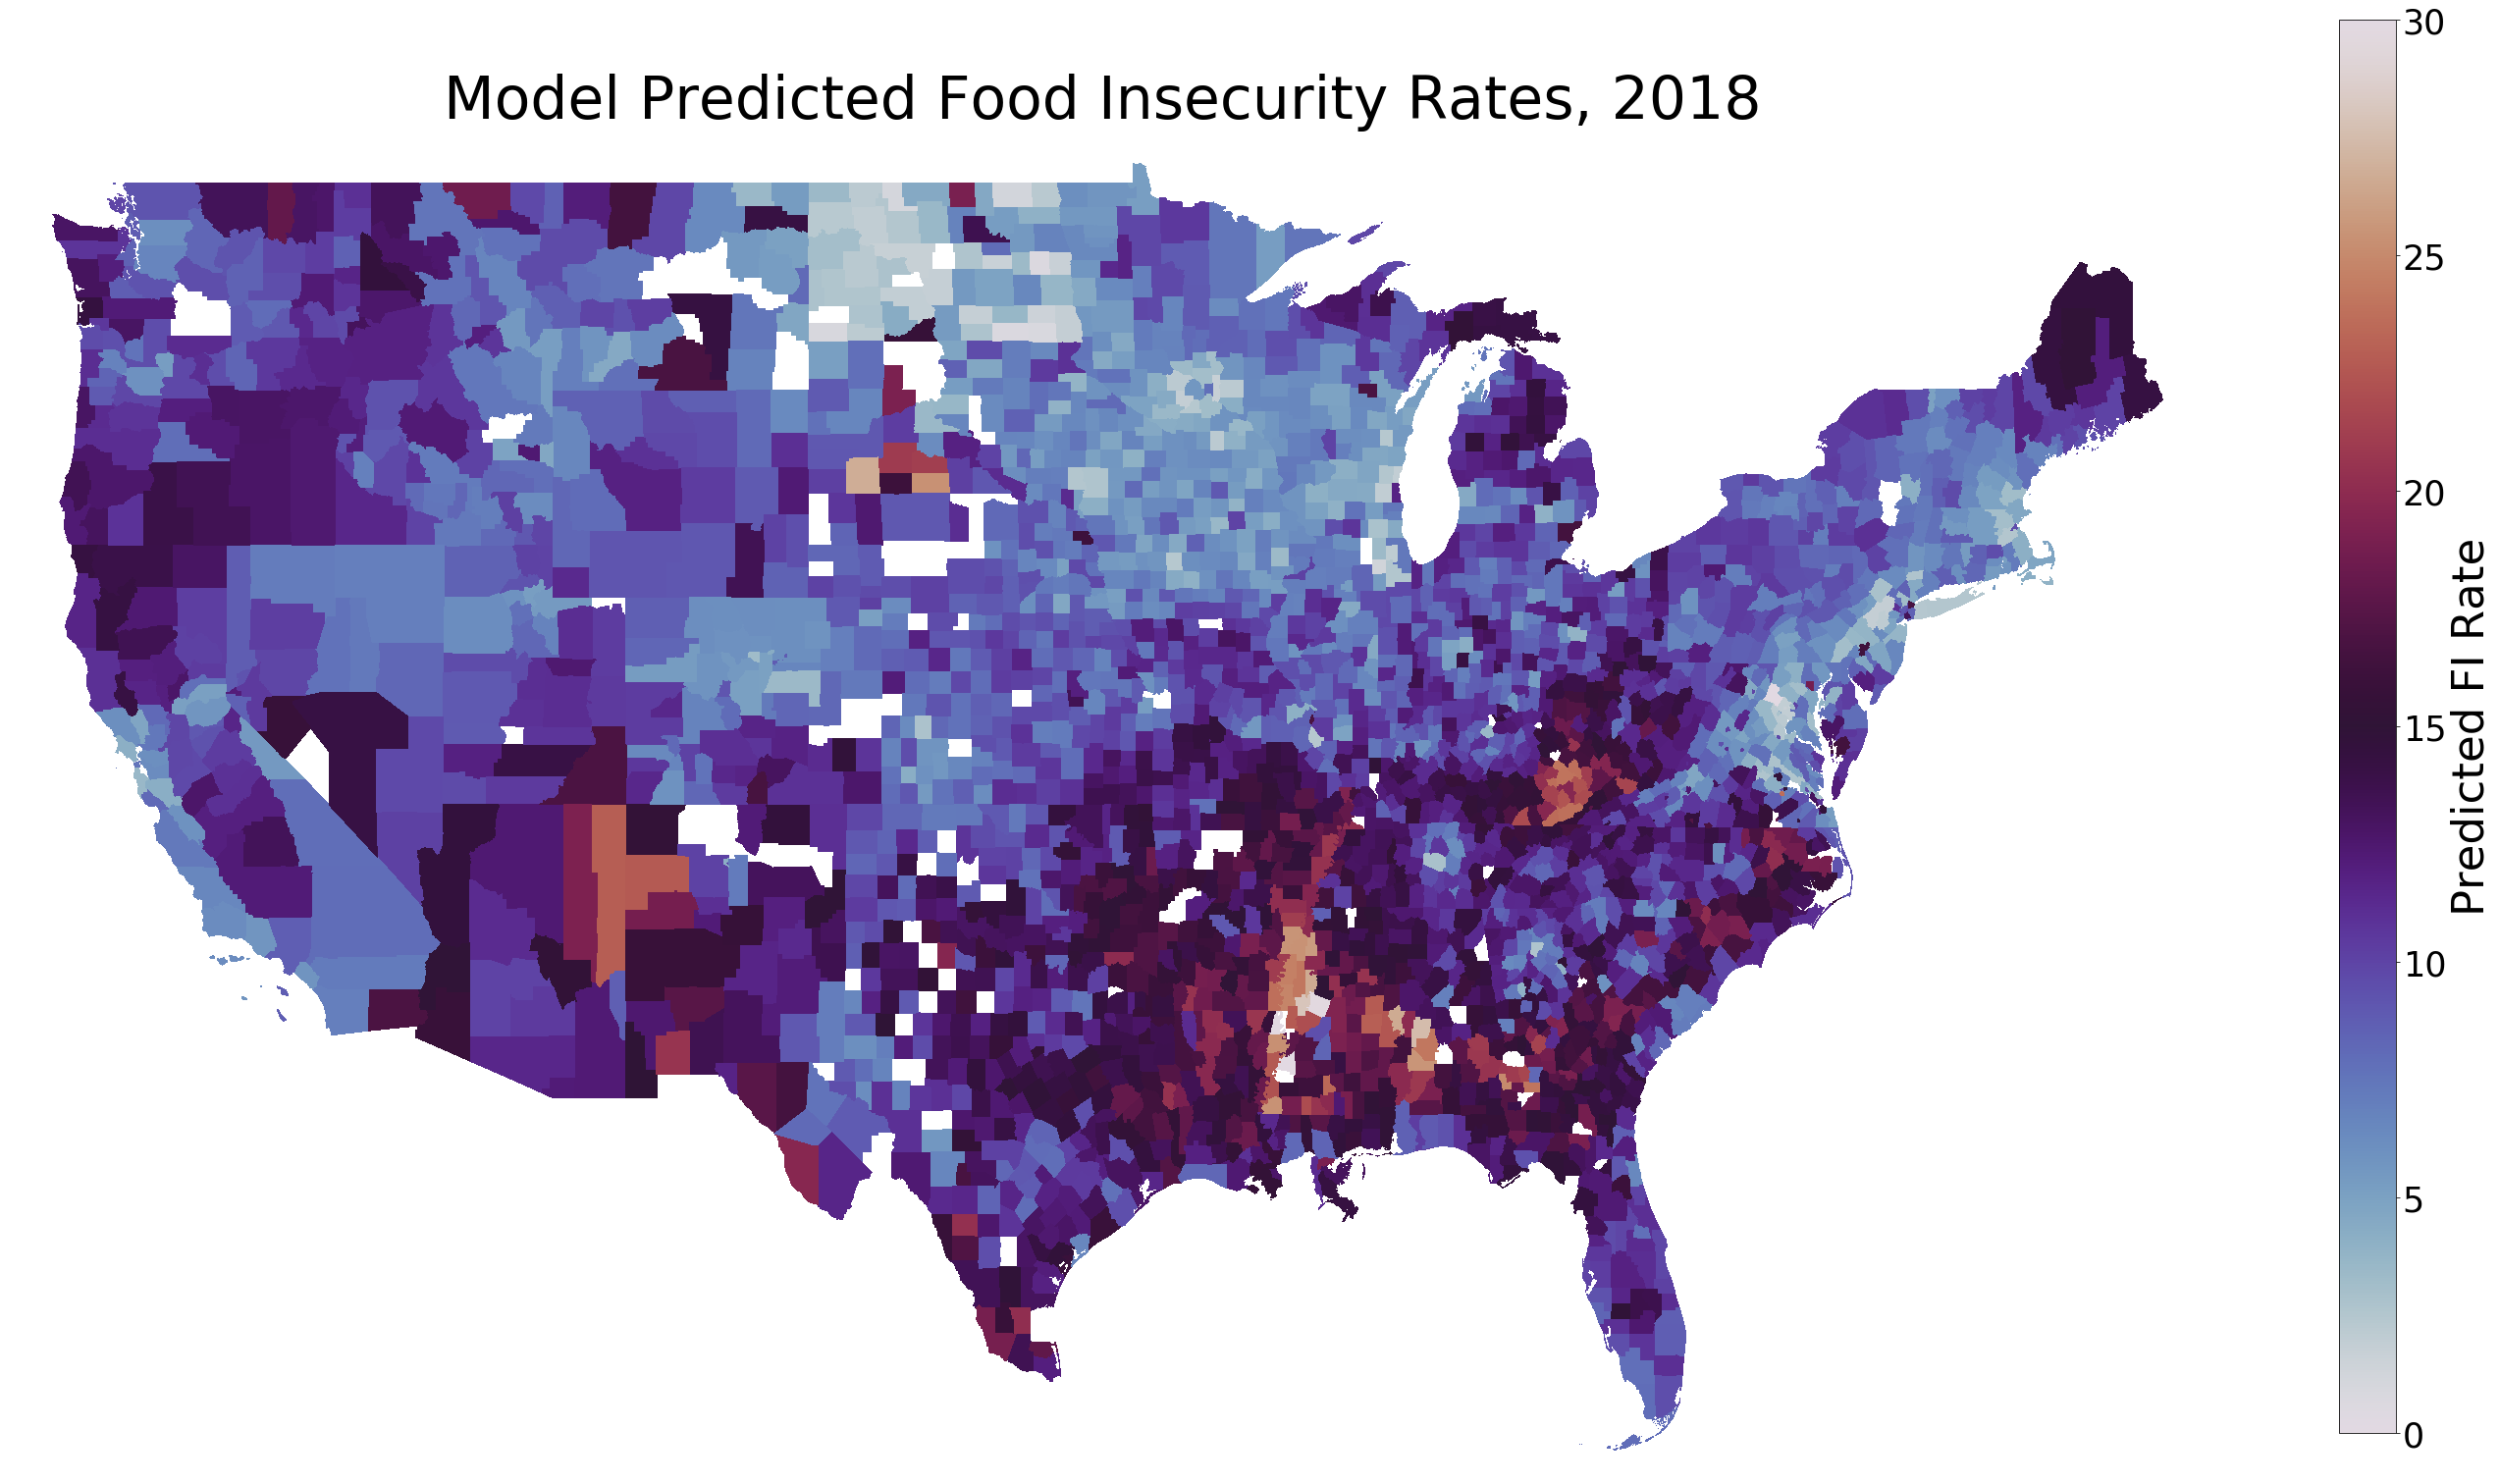

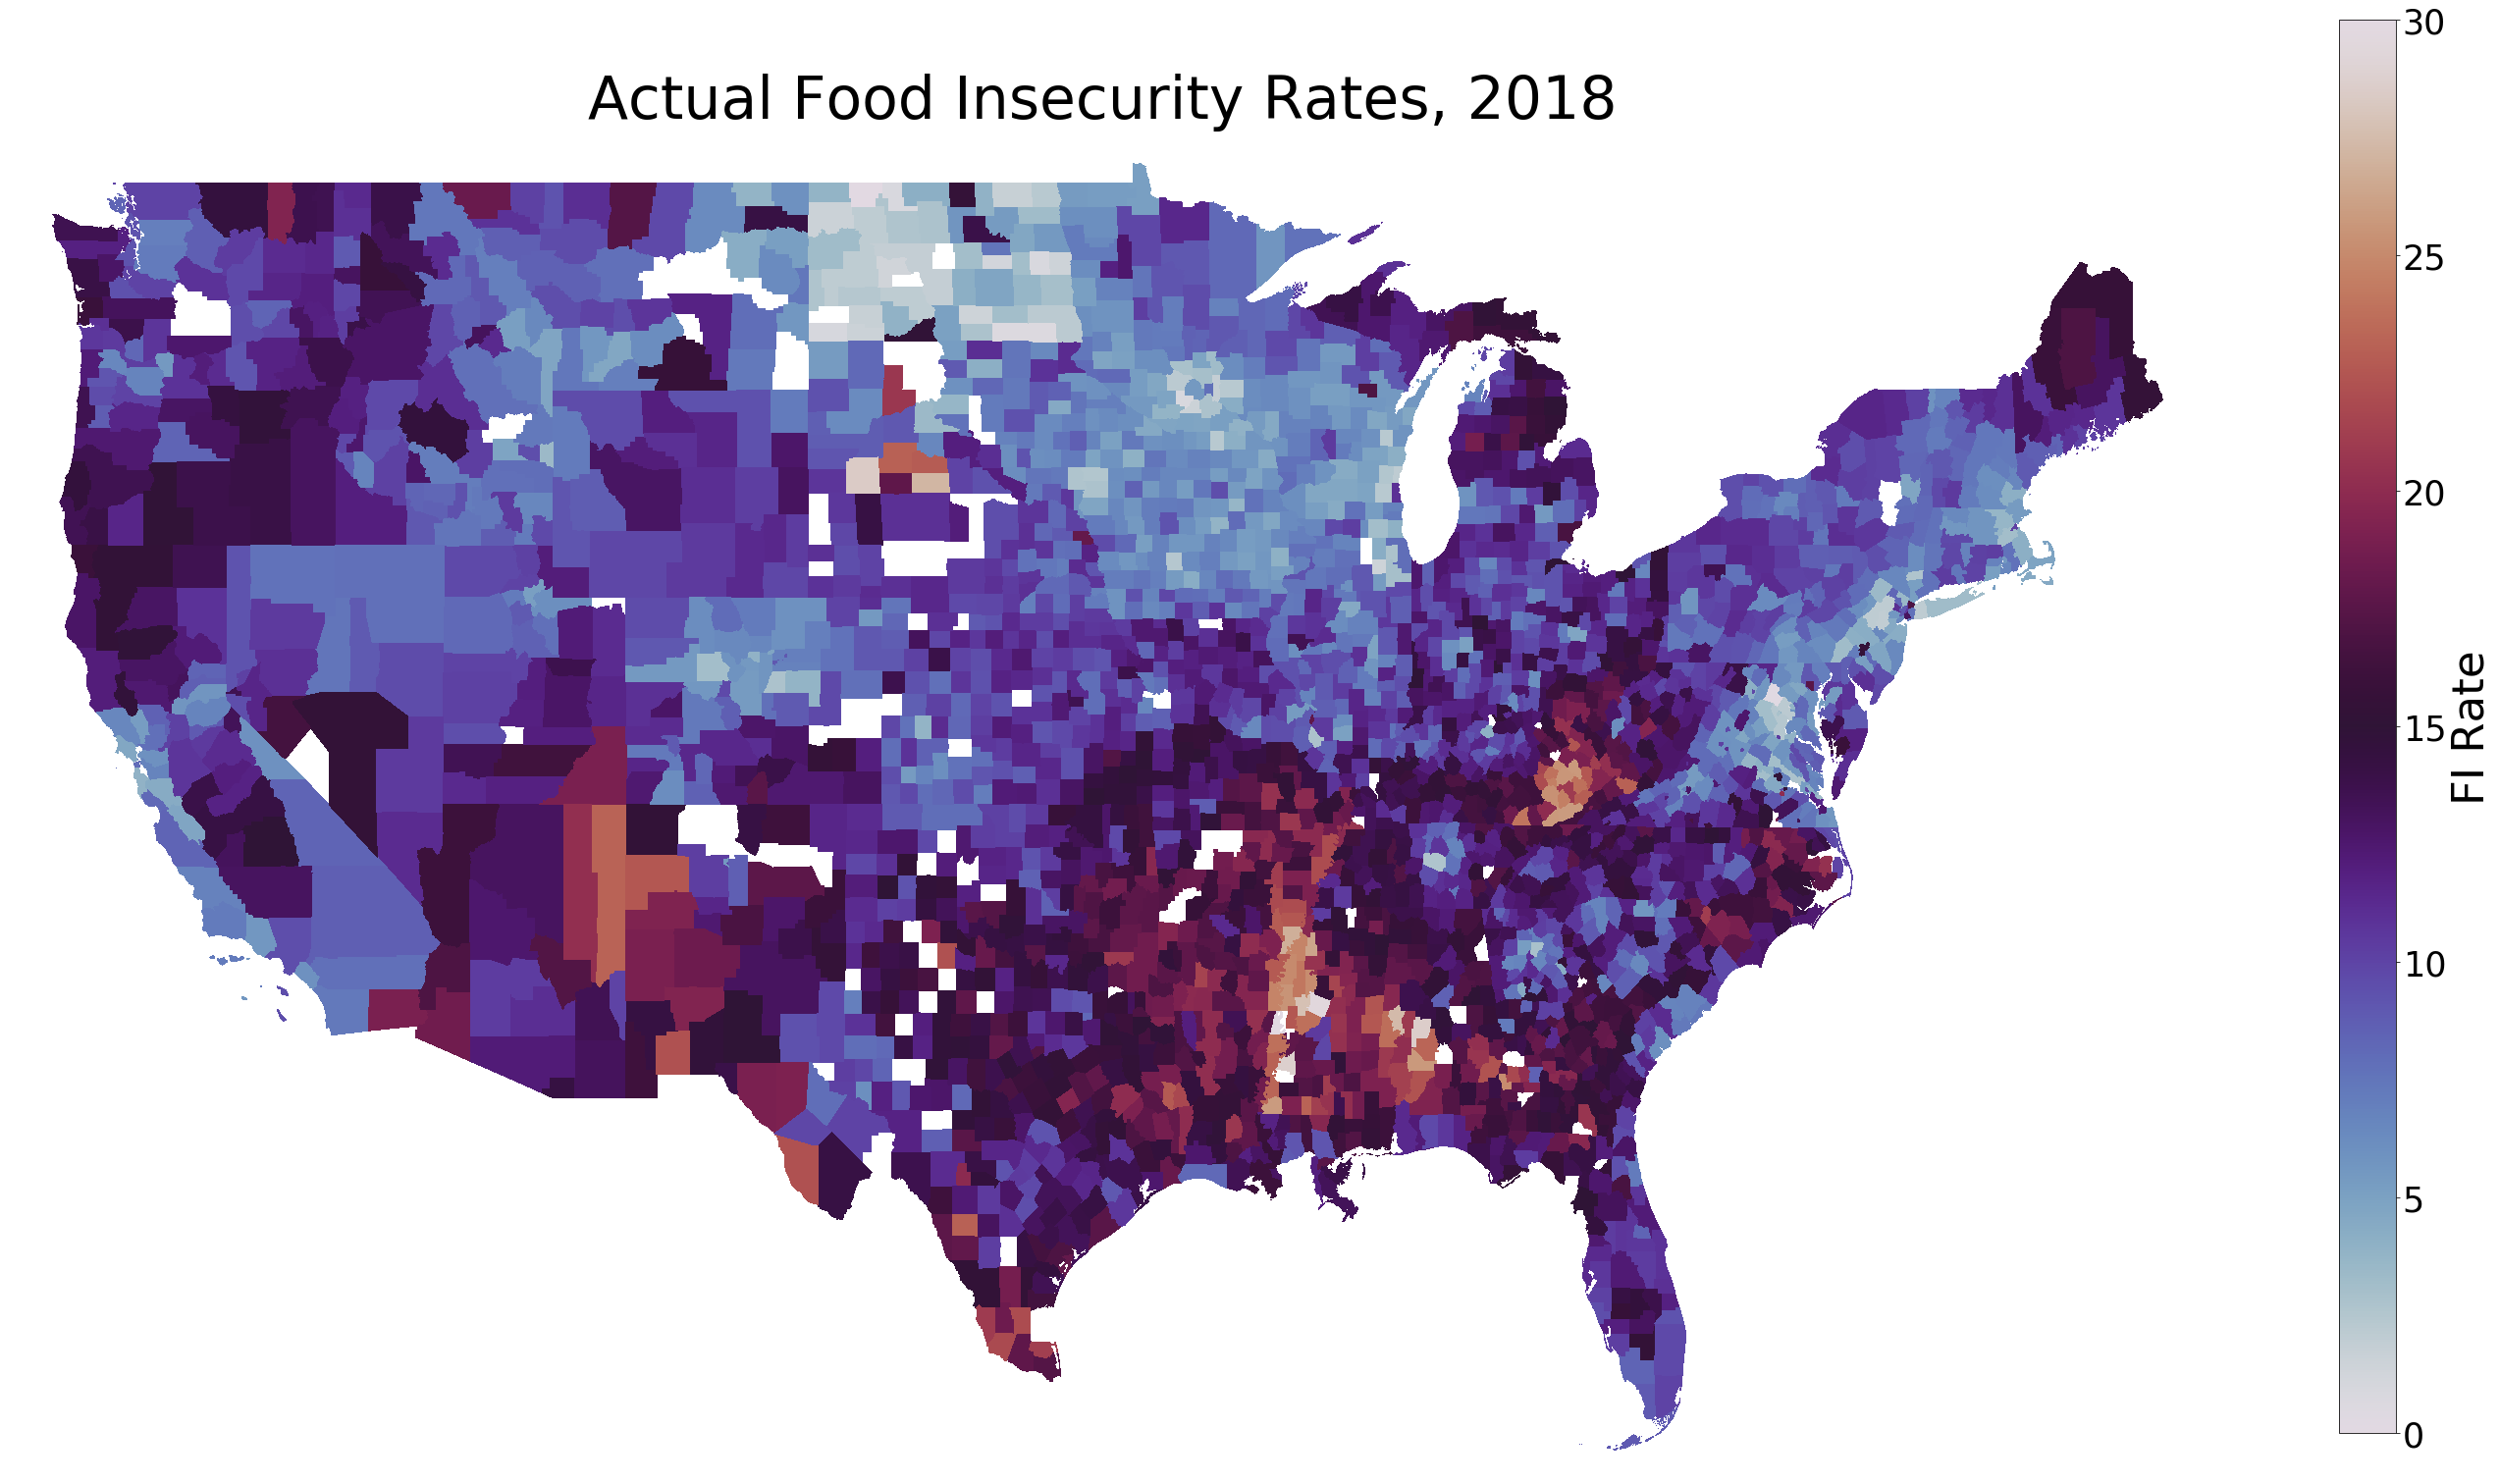

In [645]:
choropleth(df_preds,'Predicted FI Rate','2018','twilight','Model Predicted Food Insecurity Rates')
choropleth(df_preds,'FI Rate','2018','twilight', 'Actual Food Insecurity Rates')

# Unlabeled 2020 Predictions
Train model on all years, limited to the features that are available for 2020 data -- this excludes Houselessness, Food Retail, Number of Households, Vehicle Access, SNAP Benefits, and more. After the models are re-trained on labeled data, the best one is used to make predictions for 2020 food insecurity rates. 
### Drop columns that do not exist in 2020 dataset

In [665]:
df_model = df[df.Year.isin(['2010','2011','2012','2013','2014','2015','2016','2017','2018'])]

for col in df_model.columns:
    if 'Rent' in col:
        df_model.drop(col,axis=1,inplace=True)
    if 'Houseless' in col:
        df_model.drop(col,axis=1,inplace=True)
    if 'heltered' in col:
        try:
            df_model.drop(col,axis=1,inplace=True)
        except:
            pass
    if 'poverty' in col:
        df_model.drop(col,axis=1,inplace=True)
    if 'TOT_POP' in col:
        df_model.drop(col,axis=1,inplace=True)
    if 'Cost Per Meal' in col:
        df_model.drop(col,axis=1,inplace=True)
    if 'wholesale' in col:
        df_model.drop(col,axis=1,inplace=True)
    if 'restaraunt' in col:
        df_model.drop(col,axis=1,inplace=True)
    if 'num_hh'in col:
        df_model.drop(col,axis=1,inplace=True)
    if 'grocery' in col:
        try:
            df_model.drop(col,axis=1,inplace=True)
        except:
            pass
    if 'working' in col:
        try:
            df_model.drop(col,axis=1,inplace=True)
        except:
            pass
    if 'retail' in col:
        try:
            df_model.drop(col,axis=1,inplace=True)
        except:
            pass
    if '65+' in col:
        df_model.drop(col,axis=1,inplace=True)
    if 'vehicle' in col:
        df_model.drop(col,axis=1,inplace=True)
    if 'SNAP' in col:
        df_model.drop(col,axis=1,inplace=True)
#     if 'Percent_hs_grad' in col:
#         try:
#             df_model.drop(col,axis=1,inplace=True)
#         except:
#             pass

# Create dataframe for just 2018
df_model.dropna(subset=['Percent_no_health','Total_workforce','hh_med_income', 'FI Rate'],inplace=True)


### Train/Test Split the trimmed data

In [666]:
# separate target and features
y = df_model['FI Rate']
X = df_model.drop(['FIPS', 'FI Rate','Year'],axis=1)

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Perform RFE on training set

In [667]:
linreg = LinearRegression()
selector = RFECV(estimator= linreg, step=1, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
selector.fit(X_train, y_train)
rfe_features = X_train.columns[selector.support_]

## Train models and evaluate using test set
After dropping several columns that do not exist in the 2020 data, models must be rerun and evaluated to determine which model should be used to make 2020 predictions
### Random Forest

In [668]:

forest_2020 = RandomForestRegressor()
forest_2020.fit(X_train[rfe_features],y_train)
y_train_pred = forest_2020.predict(X_train[rfe_features])
y_test_pred = forest_2020.predict(X_test[rfe_features])

# R2 of training and test set
print('R2 Train:', forest_2020.score(X_train[rfe_features], y_train))
print('R2 Test:', forest_2020.score(X_test[rfe_features], y_test))

# RMSE of training and test set
print('RMSE Train:',np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('RMSE Test:',np.sqrt(mean_squared_error(y_test, y_test_pred)),'\n')

# cross validation scores
scores =cross_val_score(forest_2020, X[rfe_features], y, cv=5,  scoring='r2')
print('CV Scores:',scores)
print('Mean CV Score:',np.mean(scores))

R2 Train: 0.9879360703058113
R2 Test: 0.9131898864086323
RMSE Train: 0.004615551088530549
RMSE Test: 0.012427190203597704 

CV Scores: [0.90101227 0.88289253 0.9070856  0.74758994 0.91299519]
Mean CV Score: 0.870315106472358


### Linear Regression

In [669]:

linreg_2020 = LinearRegression()
linreg_2020.fit(X_train[rfe_features], y_train)
y_train_pred = linreg_2020.predict(X_train[rfe_features])
y_test_pred = linreg_2020.predict(X_test[rfe_features])

# R2 of training and test set
print('R2 Train:', linreg_2020.score(X_train[rfe_features], y_train))
print('R2 Test:', linreg_2020.score(X_test[rfe_features], y_test))

# RMSE of training and test set
print('RMSE Train:',np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('RMSE Test:',np.sqrt(mean_squared_error(y_test, y_test_pred)),'\n')

# cross validation scores
scores =cross_val_score(linreg_2020, X[rfe_features], y, cv=5,  scoring='r2')
print('CV Scores:',scores)
print('Mean CV Score:',np.mean(scores))

R2 Train: 0.846282399420575
R2 Test: 0.8452930968399942
RMSE Train: 0.016475589476454375
RMSE Test: 0.01658985650469148 

CV Scores: [0.86098133 0.77965441 0.83526708 0.67749829 0.89600047]
Mean CV Score: 0.8098803141953821


### Linear Regression Model Coeffients

In [670]:
sorted(list(zip(linreg_2020.coef_.tolist(), X_test.columns)), reverse=True)[:20]

[(1.0414215821689508, 'Percent_white_X_Percent_pacific'),
 (0.6424841111194772, 'Percent_pacific'),
 (0.451723070919802, 'Percent_male'),
 (0.32485017823221596, 'Percent_pacific_X_Percent_hs_grad'),
 (0.18702597963811396, 'log_Percent_female'),
 (0.16681334902650485, 'Percent_white_X_Percent_no_health'),
 (0.1604291518230655, 'Percent_hs_grad'),
 (0.14090353824762789, 'Percent_public_health'),
 (0.1273423802110451, 'Percent_white_X_Percent_priv_health'),
 (0.11347236371173132, 'Percent_Black_X_Percent_no_health'),
 (0.11260699066625054, 'Percent_Black_X_Percent_priv_health'),
 (0.10290404697652952, 'Percent_PoC'),
 (0.09023984887791549, 'log_hh_avg_size'),
 (0.07439335228618073, 'Percent_hs_grad_X_hh_avg_size'),
 (0.0579332210926367, 'Percent_disabled'),
 (0.04601772237120275, 'Percent_grad_degree'),
 (0.024234396941442443, 'log_Percent_disabled'),
 (0.010199851427008216, 'Unemployment_rate_X_Percent_non_citizen'),
 (0.007808527779828989, 'log_Percent_bachelors'),
 (0.00587400436713242

### XGBoost Regressor

In [671]:
XGB_2020 = XGBRegressor()
XGB_2020.fit(X_train[rfe_features], y_train, verbose=2)
y_test_pred = XGB_2020.predict(X_test[rfe_features])
y_train_pred = XGB_2020.predict(X_train[rfe_features])

# R2 of training and test set
print('R2 Train:', XGB_2020.score(X_train[rfe_features], y_train))
print('R2 Test:', XGB_2020.score(X_test[rfe_features], y_test))

# RMSE of training and test set
print('RMSE Train:',np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('RMSE Test:',np.sqrt(mean_squared_error(y_test, y_test_pred)),'\n')

# cross validation scores
scores =cross_val_score(XGB_2020, X[rfe_features], y, cv=5,  scoring='r2')
print('CV Scores:',scores)
print('Mean CV Score:',np.mean(scores))

[16:09:12] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R2 Train: 0.8764758201363332
R2 Test: 0.8590832183486168
RMSE Train: 0.014769139
RMSE Test: 0.015833218 

[16:09:20] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:09:28] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:09:36] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:09:44] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:09:52] WARNING: /usr

### Neural Network Regressor

In [713]:
NN_2020 = Sequential()

# The Input Layer
NN_2020.add(Dense(X[rfe_features].shape[1], kernel_initializer='normal',input_dim = X[rfe_features].shape[1], activation='relu'))

# The Hidden Layers
NN_2020.add(Dense(100,activation='relu'))

# The Output Layer
NN_2020.add(Dense(1,activation='linear'))
              
# Compile the network
NN_2020.compile(loss= 'mse', optimizer='adam',metrics=['mse'])
NN_2020.summary()


Model: "sequential_123"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_372 (Dense)            (None, 68)                4692      
_________________________________________________________________
dense_373 (Dense)            (None, 100)               6900      
_________________________________________________________________
dense_374 (Dense)            (None, 1)                 101       
Total params: 11,693
Trainable params: 11,693
Non-trainable params: 0
_________________________________________________________________


In [714]:
NN_2020.fit(X[rfe_features], y, epochs=5, batch_size=10, validation_split = 0.2)


Epoch 1/5
1567/1567 [==============================] - 4s 2ms/step - loss: 19200570.9758 - mse: 19200570.4635 - val_loss: 4324305.0000 - val_mse: 4324305.0000
Epoch 2/5
1567/1567 [==============================] - 2s 2ms/step - loss: 1236919.2342 - mse: 1236919.2342 - val_loss: 1401935.0000 - val_mse: 1401935.0000
Epoch 3/5
1567/1567 [==============================] - 2s 2ms/step - loss: 677788.3807 - mse: 677788.3807 - val_loss: 236324.5625 - val_mse: 236324.5625
Epoch 4/5
1567/1567 [==============================] - 3s 2ms/step - loss: 158571.5519 - mse: 158571.5519 - val_loss: 470.5269 - val_mse: 470.5269
Epoch 5/5
1567/1567 [==============================] - 3s 2ms/step - loss: 9172.5414 - mse: 9172.5414 - val_loss: 325015.7812 - val_mse: 325015.8125


### Feature Importance

## Predict on Unlabeled 2020 Data
Use the newly trained model to make predictions on the unlabeled data for 2020 food insecurity rates

In [676]:
df_20 = df[df.Year=='2020']
df_20.drop(['FI Rate'],axis=1,inplace=True)

for col in df_20.columns:
    if 'Rent' in col:
        df_20.drop(col,axis=1,inplace=True)
    if 'Houseless' in col:
        df_20.drop(col,axis=1,inplace=True)
    if 'heltered' in col:
        try:
            df_20.drop(col,axis=1,inplace=True)
        except:
            pass
    if 'poverty' in col:
        df_20.drop(col,axis=1,inplace=True)
    if 'TOT_POP' in col:
        df_20.drop(col,axis=1,inplace=True)
    if 'Cost Per Meal' in col:
        df_20.drop(col,axis=1,inplace=True)
    if 'wholesale' in col:
        df_20.drop(col,axis=1,inplace=True)
    if 'restaraunt' in col:
        df_20.drop(col,axis=1,inplace=True)
    if 'num_hh'in col:
        df_20.drop(col,axis=1,inplace=True)
    if 'grocery' in col:
        try:
            df_20.drop(col,axis=1,inplace=True)
        except:
            pass
    if 'working' in col:
        try:
            df_20.drop(col,axis=1,inplace=True)
        except:
            pass
    if 'retail' in col:
        try:
            df_20.drop(col,axis=1,inplace=True)
        except:
            pass
    if '65+' in col:
        df_20.drop(col,axis=1,inplace=True)
    if 'vehicle' in col:
        df_20.drop(col,axis=1,inplace=True)
    if 'SNAP' in col:
        df_20.drop(col,axis=1,inplace=True)
#     if 'Percent_hs_grad' in col:
#         try:
#             df_20.drop(col,axis=1,inplace=True)
#         except:
#             pass

df_20.dropna(subset=['Percent_male','hh_avg_size','hh_med_income'],inplace=True)

,FIPS,Year,hh_med_income,hh_avg_size,Total_workforce,Employed,Unemployed,Unemployment_rate,Percent_male,Percent_female,Percent_white,Percent_Black,Percent_native,Percent_asian,Percent_pacific,Percent_latinX,Percent_PoC,Percent_disabled,Percent_hs_grad,Percent_bachelors,Percent_grad_degree,Percent_priv_health,Percent_public_health,Percent_no_health,Percent_non_citizen,Unemployment_rate_X_Percent_Black,Unemployment_rate_X_Percent_white,Unemployment_rate_X_Percent_latinX,Percent_latinX_X_hh_med_income,Unemployment_rate_X_hh_avg_size,Percent_Black_X_Percent_grad_degree,Percent_pacific_X_Percent_hs_grad,Unemployment_rate_X_Percent_non_citizen,Percent_white_X_Percent_grad_degree,Unemployment_rate_X_Percent_female,Unemployment_rate_X_Percent_male,Percent_pacific_X_Percent_public_health,Percent_Black_X_Percent_hs_grad,Percent_white_X_Percent_priv_health,Percent_white_X_Percent_pacific,Unemployment_rate_X_Percent_hs_grad,Unemployment_rate_X_Percent_disabled,Percent_white_X_Percent_no_health,Percent_female_X_Percent_hs_grad,Percent_Black_X_Percent_no_health,Percent_pacific_X_Percent_disabled,Percent_Black_X_hh_med_income,Percent_Black_X_Percent_priv_health,Percent_hs_grad_X_hh_avg_size,Percent_latinX_X_Percent_priv_health,log_Unemployment_rate,log_Percent_male,log_Percent_female,log_Percent_white,log_Percent_Black,log_Percent_native,log_Percent_asian,log_Percent_pacific,log_Percent_latinX,log_Percent_disabled,log_Percent_hs_grad,log_Percent_bachelors,log_Percent_grad_degree,log_Percent_priv_health,log_Percent_public_health,log_Percent_no_health,log_Percent_non_citizen,log_hh_avg_size,log_hh_med_income,Hi_thresh_other
0,01073,2020,54302.565258,1.649676,317405.0,295757.6,21647.4,6.82,0.472676,0.527313,0.529601,0.438541,0.002862,0.018639,0.000599,0.041957,0.475547,0.025895,0.384496,0.147515,0.089774,0.737636,0.496157,0.045649,0.018711,2.990847,3.611876,0.286149,2278.386998,11.250790,0.039370,0.000230,0.127606,0.047545,3.596277,3.223651,0.000297,0.168617,0.390652,0.000317,2.622260,0.176602,0.024176,0.202750,0.020019,0.000016,23813.880739,0.323483,0.634293,0.030949,1.919859,-0.749345,-0.639960,-0.635632,-0.824303,-5.856143,-3.982484,-7.419527,-3.171104,-3.653717,-0.955823,-1.913827,-2.410457,-0.304305,-0.700862,-3.086783,-3.978665,0.500579,10.902327,0
1,01117,2020,79147.668222,1.776574,113265.6,108327.0,4938.6,4.38,0.483336,0.516658,0.823653,0.134382,0.004013,0.023557,0.000527,0.059677,0.176941,0.018425,0.285176,0.203412,0.098840,0.864214,0.337877,0.032084,0.023183,0.588595,3.607601,0.261386,4723.303679,7.781395,0.013282,0.000150,0.101540,0.081410,2.262960,2.117011,0.000178,0.038323,0.711813,0.000434,1.249069,0.080702,0.026426,0.147338,0.004312,0.000010,10636.049259,0.116135,0.506636,0.051574,1.477049,-0.727043,-0.660375,-0.194006,-2.007066,-5.518102,-3.748327,-7.548469,-2.818807,-3.994041,-1.254650,-1.592522,-2.314256,-0.145935,-1.085074,-3.439391,-3.764351,0.574687,11.279071,0
2,04003,2020,50823.707598,1.589566,51487.3,47766.5,3720.8,7.25,0.506419,0.493584,0.875404,0.045477,0.017797,0.023523,0.004268,0.367358,0.124389,0.026485,0.343544,0.108584,0.062698,0.639360,0.661645,0.036652,0.034888,0.329709,6.346677,2.663348,18670.516577,11.524356,0.002851,0.001466,0.252935,0.054886,3.578483,3.671535,0.002824,0.015623,0.559698,0.003736,2.490695,0.192016,0.032085,0.169568,0.001667,0.000113,2311.312581,0.029076,0.546086,0.234874,1.981001,-0.680392,-0.706063,-0.133070,-3.090547,-4.028751,-3.749772,-5.456706,-1.001417,-3.631177,-1.068440,-2.220232,-2.769431,-0.447288,-0.413026,-3.306299,-3.355623,0.463461,10.836118,0
3,05119,2020,52332.257286,1.642997,187556.9,171955.6,15601.3,8.33,0.477192,0.522799,0.570346,0.381889,0.004518,0.023532,0.000517,0.064261,0.434171,0.025749,0.375347,0.155338,0.093706,0.707271,0.556736,0.041235,0.024338,3.181134,4.750979,0.535297,3362.938414,13.686166,0.035785,0.000194,0.202738,0.053445,4.354915,3.975012,0.000288,0.143341,0.403389,0.000295,3.126639,0.214493,0.023518,0.196231,0.015747,0.000013,19985.107712,0.270099,0.616694,0

In [677]:
df_18 = df[df.Year=='2018']

for col in df_18.columns:
    if 'Rent' in col:
        df_18.drop(col,axis=1,inplace=True)
    if 'Houseless' in col:
        df_18.drop(col,axis=1,inplace=True)
    if 'heltered' in col:
        try:
            df_18.drop(col,axis=1,inplace=True)
        except:
            pass
    if 'poverty' in col:
        df_18.drop(col,axis=1,inplace=True)
    if 'TOT_POP' in col:
        df_18.drop(col,axis=1,inplace=True)
    if 'Cost Per Meal' in col:
        df_18.drop(col,axis=1,inplace=True)
    if 'wholesale' in col:
        df_18.drop(col,axis=1,inplace=True)
    if 'restaraunt' in col:
        df_18.drop(col,axis=1,inplace=True)
    if 'num_hh'in col:
        df_18.drop(col,axis=1,inplace=True)
    if 'grocery' in col:
        try:
            df_18.drop(col,axis=1,inplace=True)
        except:
            pass
    if 'working' in col:
        try:
            df_18.drop(col,axis=1,inplace=True)
        except:
            pass
    if 'retail' in col:
        try:
            df_18.drop(col,axis=1,inplace=True)
        except:
            pass
    if '65+' in col:
        df_18.drop(col,axis=1,inplace=True)
    if 'vehicle' in col:
        df_18.drop(col,axis=1,inplace=True)
    if 'SNAP' in col:
        df_18.drop(col,axis=1,inplace=True)
#     if 'Percent_hs_grad' in col:
#         try:
#             df_18.drop(col,axis=1,inplace=True)
#         except:
#             pass

df_18.dropna(subset=['Percent_male','hh_avg_size','hh_med_income','Total_workforce'],inplace=True)

### Make Predictions

In [719]:
preds_18 = NN_2020.predict(df_18[rfe_features]) 
preds_20 = NN_2020.predict(df_20[rfe_features])
df_preds_20 = pd.concat([df_20.reset_index(), pd.Series(preds_20)],axis=1).rename(columns={0:'Pred FI Rate 2020'})
df_preds_18 = pd.concat([df_18.reset_index(), pd.Series(preds_18)],axis=1).rename(columns={0:'Pred FI Rate 2018'})


,FIPS,Year,hh_med_income,hh_avg_size,FI Rate,Total_workforce,Employed,Unemployed,Unemployment_rate,Percent_male,Percent_female,Percent_white,Percent_Black,Percent_native,Percent_asian,Percent_pacific,Percent_latinX,Percent_PoC,Percent_disabled,Percent_hs_grad,Percent_bachelors,Percent_grad_degree,Percent_priv_health,Percent_public_health,Percent_no_health,Percent_non_citizen,Unemployment_rate_X_Percent_Black,Unemployment_rate_X_Percent_white,Unemployment_rate_X_Percent_latinX,Percent_latinX_X_hh_med_income,Unemployment_rate_X_hh_avg_size,Percent_Black_X_Percent_grad_degree,Percent_pacific_X_Percent_hs_grad,Unemployment_rate_X_Percent_non_citizen,Percent_white_X_Percent_grad_degree,Unemployment_rate_X_Percent_female,Unemployment_rate_X_Percent_male,Percent_pacific_X_Percent_public_health,Percent_Black_X_Percent_hs_grad,Percent_white_X_Percent_priv_health,Percent_white_X_Percent_pacific,Unemployment_rate_X_Percent_hs_grad,Unemployment_rate_X_Percent_disabled,Percent_white_X_Percent_no_health,Percent_female_X_Percent_hs_grad,Percent_Black_X_Percent_no_health,Percent_pacific_X_Percent_disabled,Percent_Black_X_hh_med_income,Percent_Black_X_Percent_priv_health,Percent_hs_grad_X_hh_avg_size,Percent_latinX_X_Percent_priv_health,log_Unemployment_rate,log_Percent_male,log_Percent_female,log_Percent_white,log_Percent_Black,log_Percent_native,log_Percent_asian,log_Percent_pacific,log_Percent_latinX,log_Percent_disabled,log_Percent_hs_grad,log_Percent_bachelors,log_Percent_grad_degree,log_Percent_priv_health,log_Percent_public_health,log_Percent_no_health,log_Percent_non_citizen,log_hh_avg_size,log_hh_med_income,Hi_thresh_other,Pred FI Rate 2018
0,01073,2018,51979.0,2.47,0.161,315793.0,304248.0,11545.0,3.7,0.472615,0.527385,0.532103,0.433916,0.002866,0.017649,0.000546,0.039683,0.467897,0.153713,0.182032,0.134627,0.085961,0.671256,0.346341,0.094269,0.026779,1.605490,1.968780,0.146826,2062.673119,9.139,0.037300,0.000099,0.099083,0.045740,1.951325,1.748675,0.000189,0.078987,0.357177,0.000290,0.673517,0.568739,0.050161,0.096001,0.040905,0.000084,22554.536005,0.291269,0.449618,0.026637,1.308333,-0.749474,-0.639824,-0.630919,-0.834904,-5.854797,-4.037099,-7.513026,-3.226837,-1.872666,-1.703574,-2.005247,-2.453865,-0.398604,-1.060333,-2.361598,-3.620129,0.904218,10.858595,1,641.480530
1,01117,2018,75761.0,2.66,0.106,114634.0,111425.0,3209.0,2.8,0.483211,0.516789,0.829653,0.129611,0.003906,0.022321,0.000547,0.057514,0.170347,0.109373,0.135011,0.185641,0.094641,0.786444,0.235853,0.066258,0.033180,0.362912,2.323027,0.161039,4357.303864,7.448,0.012267,0.000074,0.092903,0.078519,1.447010,1.352990,0.000129,0.017499,0.652475,0.000454,0.378030,0.306245,0.054971,0.069772,0.008588,0.000060,9819.484199,0.101932,0.359128,0.045231,1.029619,-0.727303,-0.660120,-0.186748,-2.043215,-5.545321,-3.802233,-7.510417,-2.855730,-2.212990,-2.002402,-1.683942,-2.357664,-0.240234,-1.444545,-2.714206,-3.405814,0.978326,11.235339,1,144.931442
2,04003,2018,48649.0,2.38,0.144,49482.0,46751.0,2731.0,5.5,0.507234,0.492766,0.877701,0.046349,0.017293,0.022284,0.004153,0.355467,0.122299,0.157217,0.162644,0.099097,0.060034,0.581824,0.461859,0.075690,0.049932,0.254918,4.827353,1.955071,17293.137583,13.090,0.002783,0.000675,0.274628,0.052692,2.710211,2.789789,0.001918,0.007538,0.510668,0.003645,0.894542,0.864695,0.066433,0.080145,0.003508,0.000653,2254.823481,0.026967,0.387093,0.206820,1.704748,-0.678782,-0.707722,-0.130450,-3.071560,-4.057465,-3.803866,-5.483896,-1.034322,-1.850126,-1.816191,-2.311652,-2.812839,-0.541587,-0.772497,-2.581114,-2.997086,0.867100,10.792387,0,60.878239
3,04013,2018,61606.0,2.76,0.121,2217163.0,2127021.0,90142.0,4.1,0.494400,0.505600,0.830898,0.062667,0.028143,0.045523,0.002849,0.312215,0.169102,0.106567,0.144196,0.129795,0.074428,0.624850,0.325432,0.106392,0.086160,0.256934,3.406680,1.280082,19234.327748,11.316,0.004664,0.000411,0.353255,0.061842,2.072959,2.027041,0.000927,0.009036,0.519187,0.002367,0.591205,0.436925,0.088401,0.072906,0.006667,0.000304,3

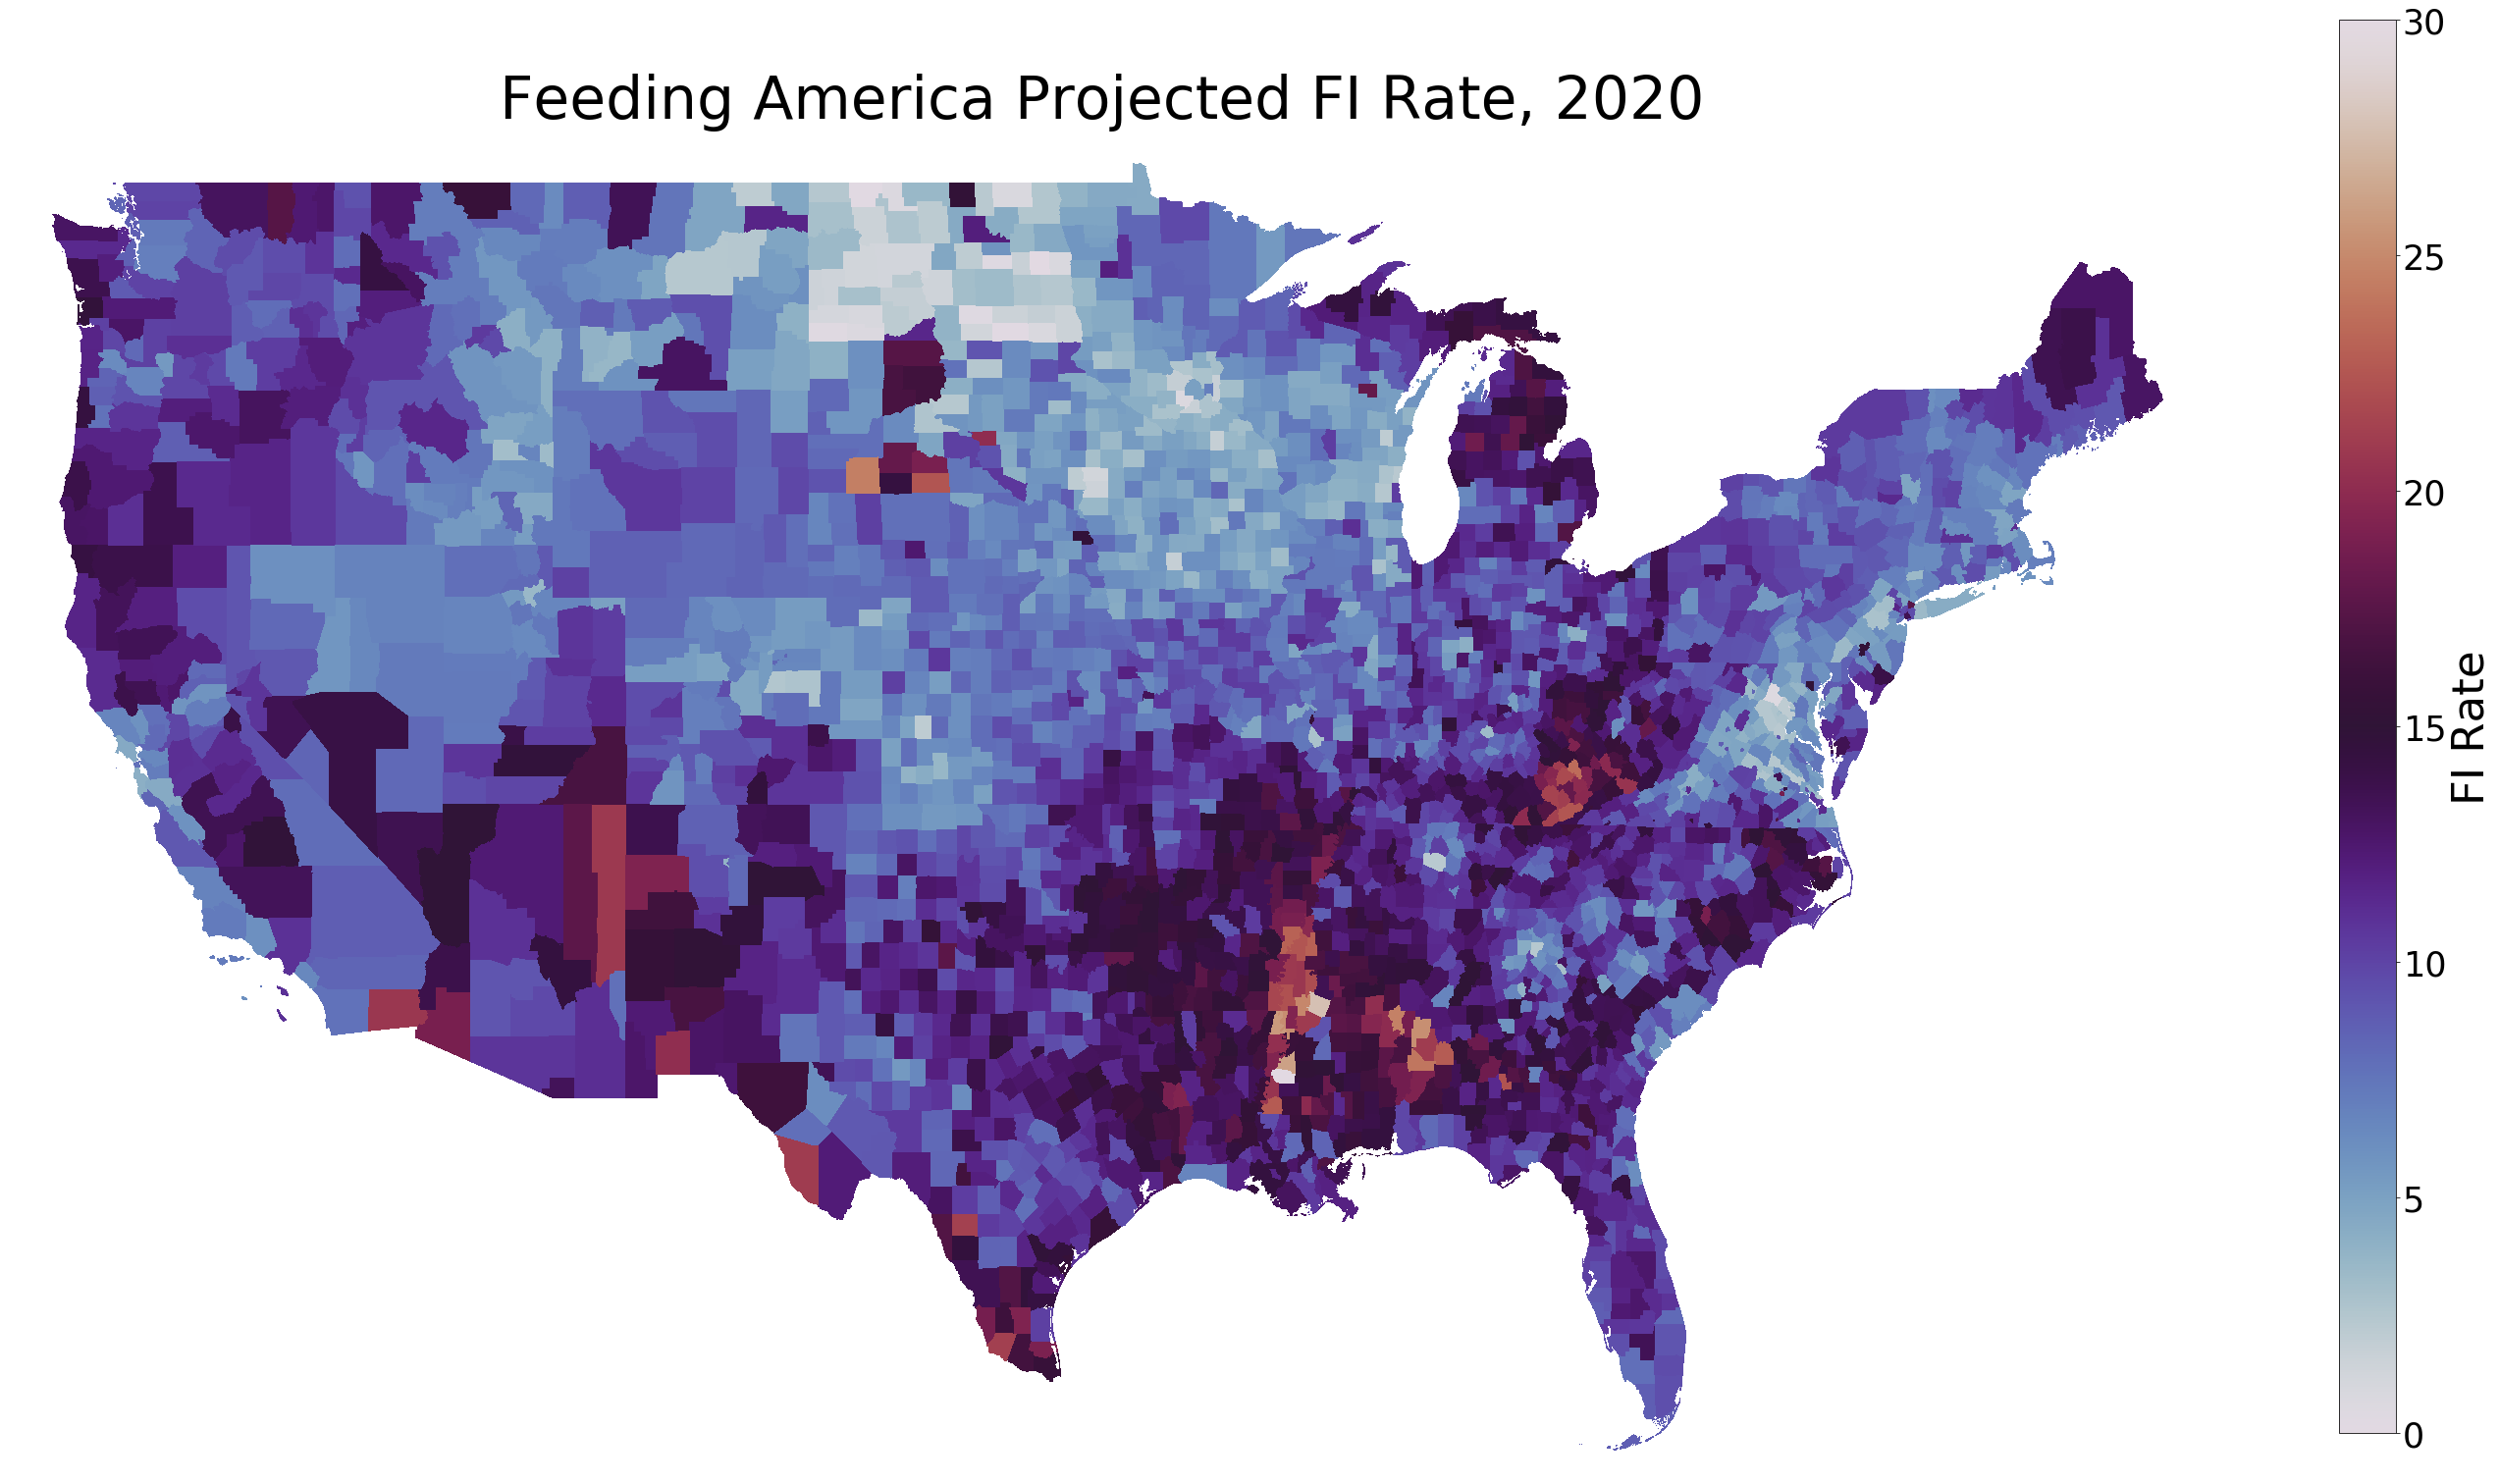

In [465]:
choropleth(df_projected,'FI Rate','2020','twilight', 'Feeding America Projected FI Rate')

### Map Predictions

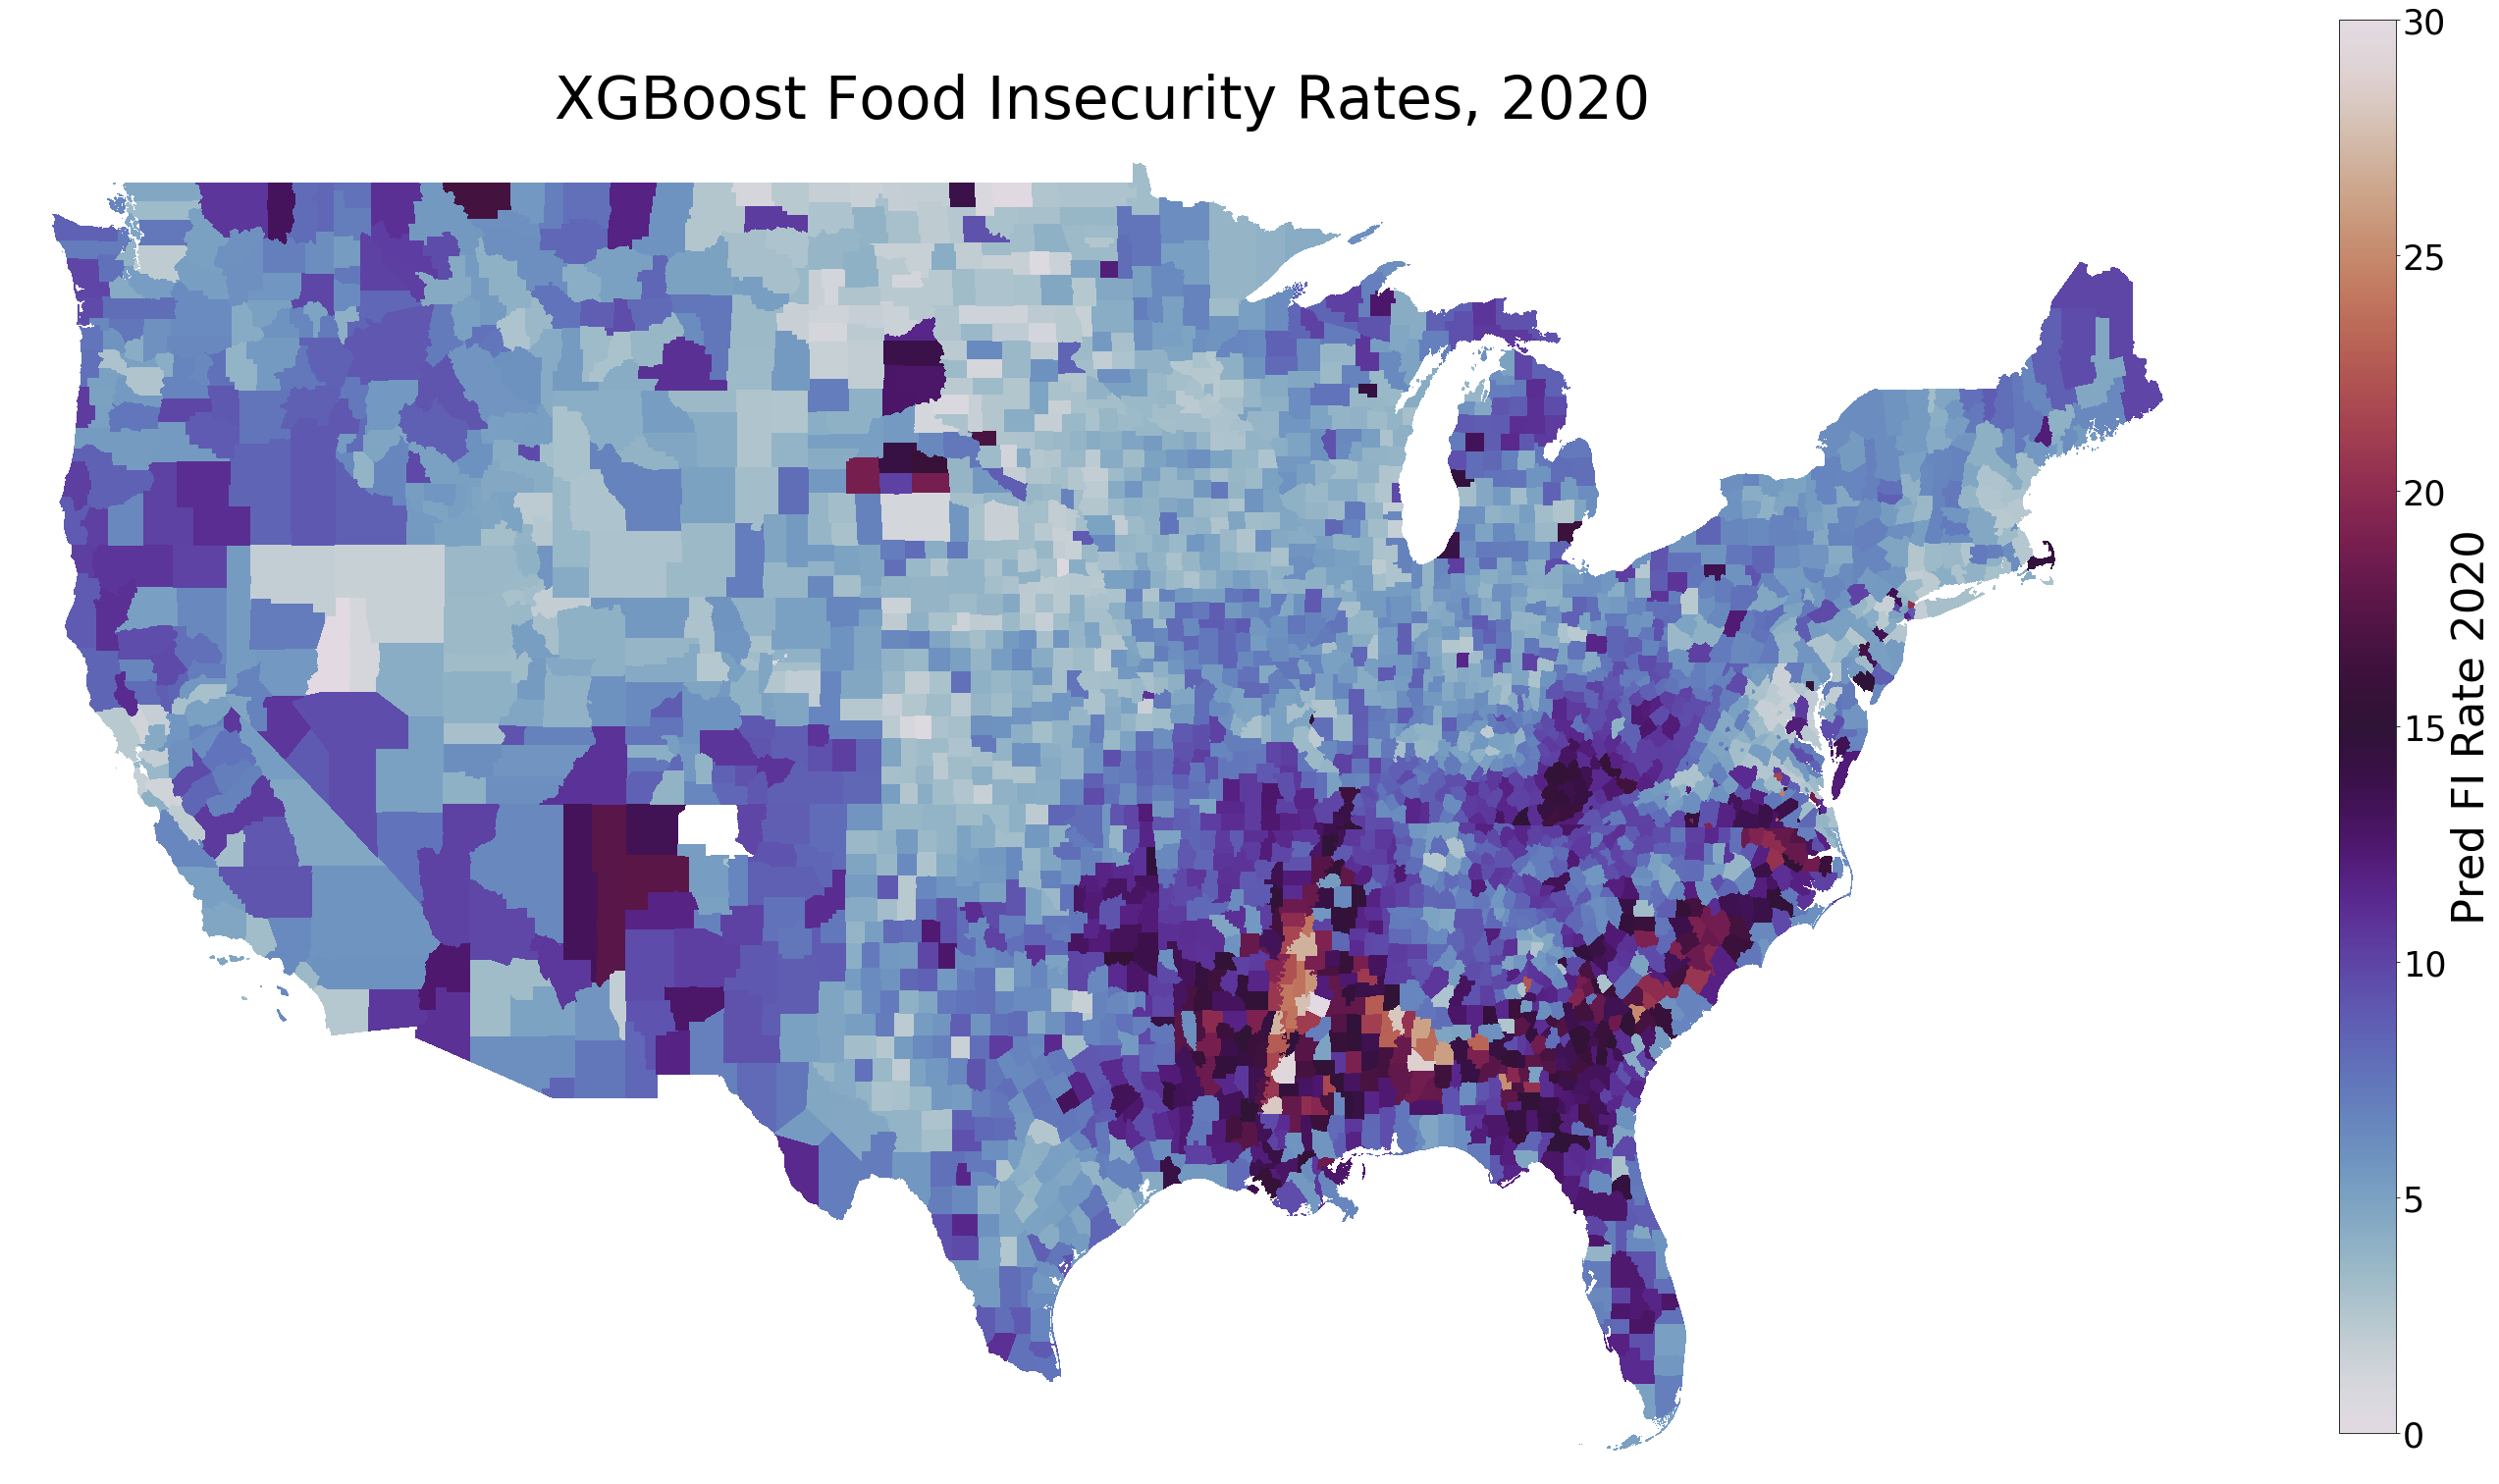

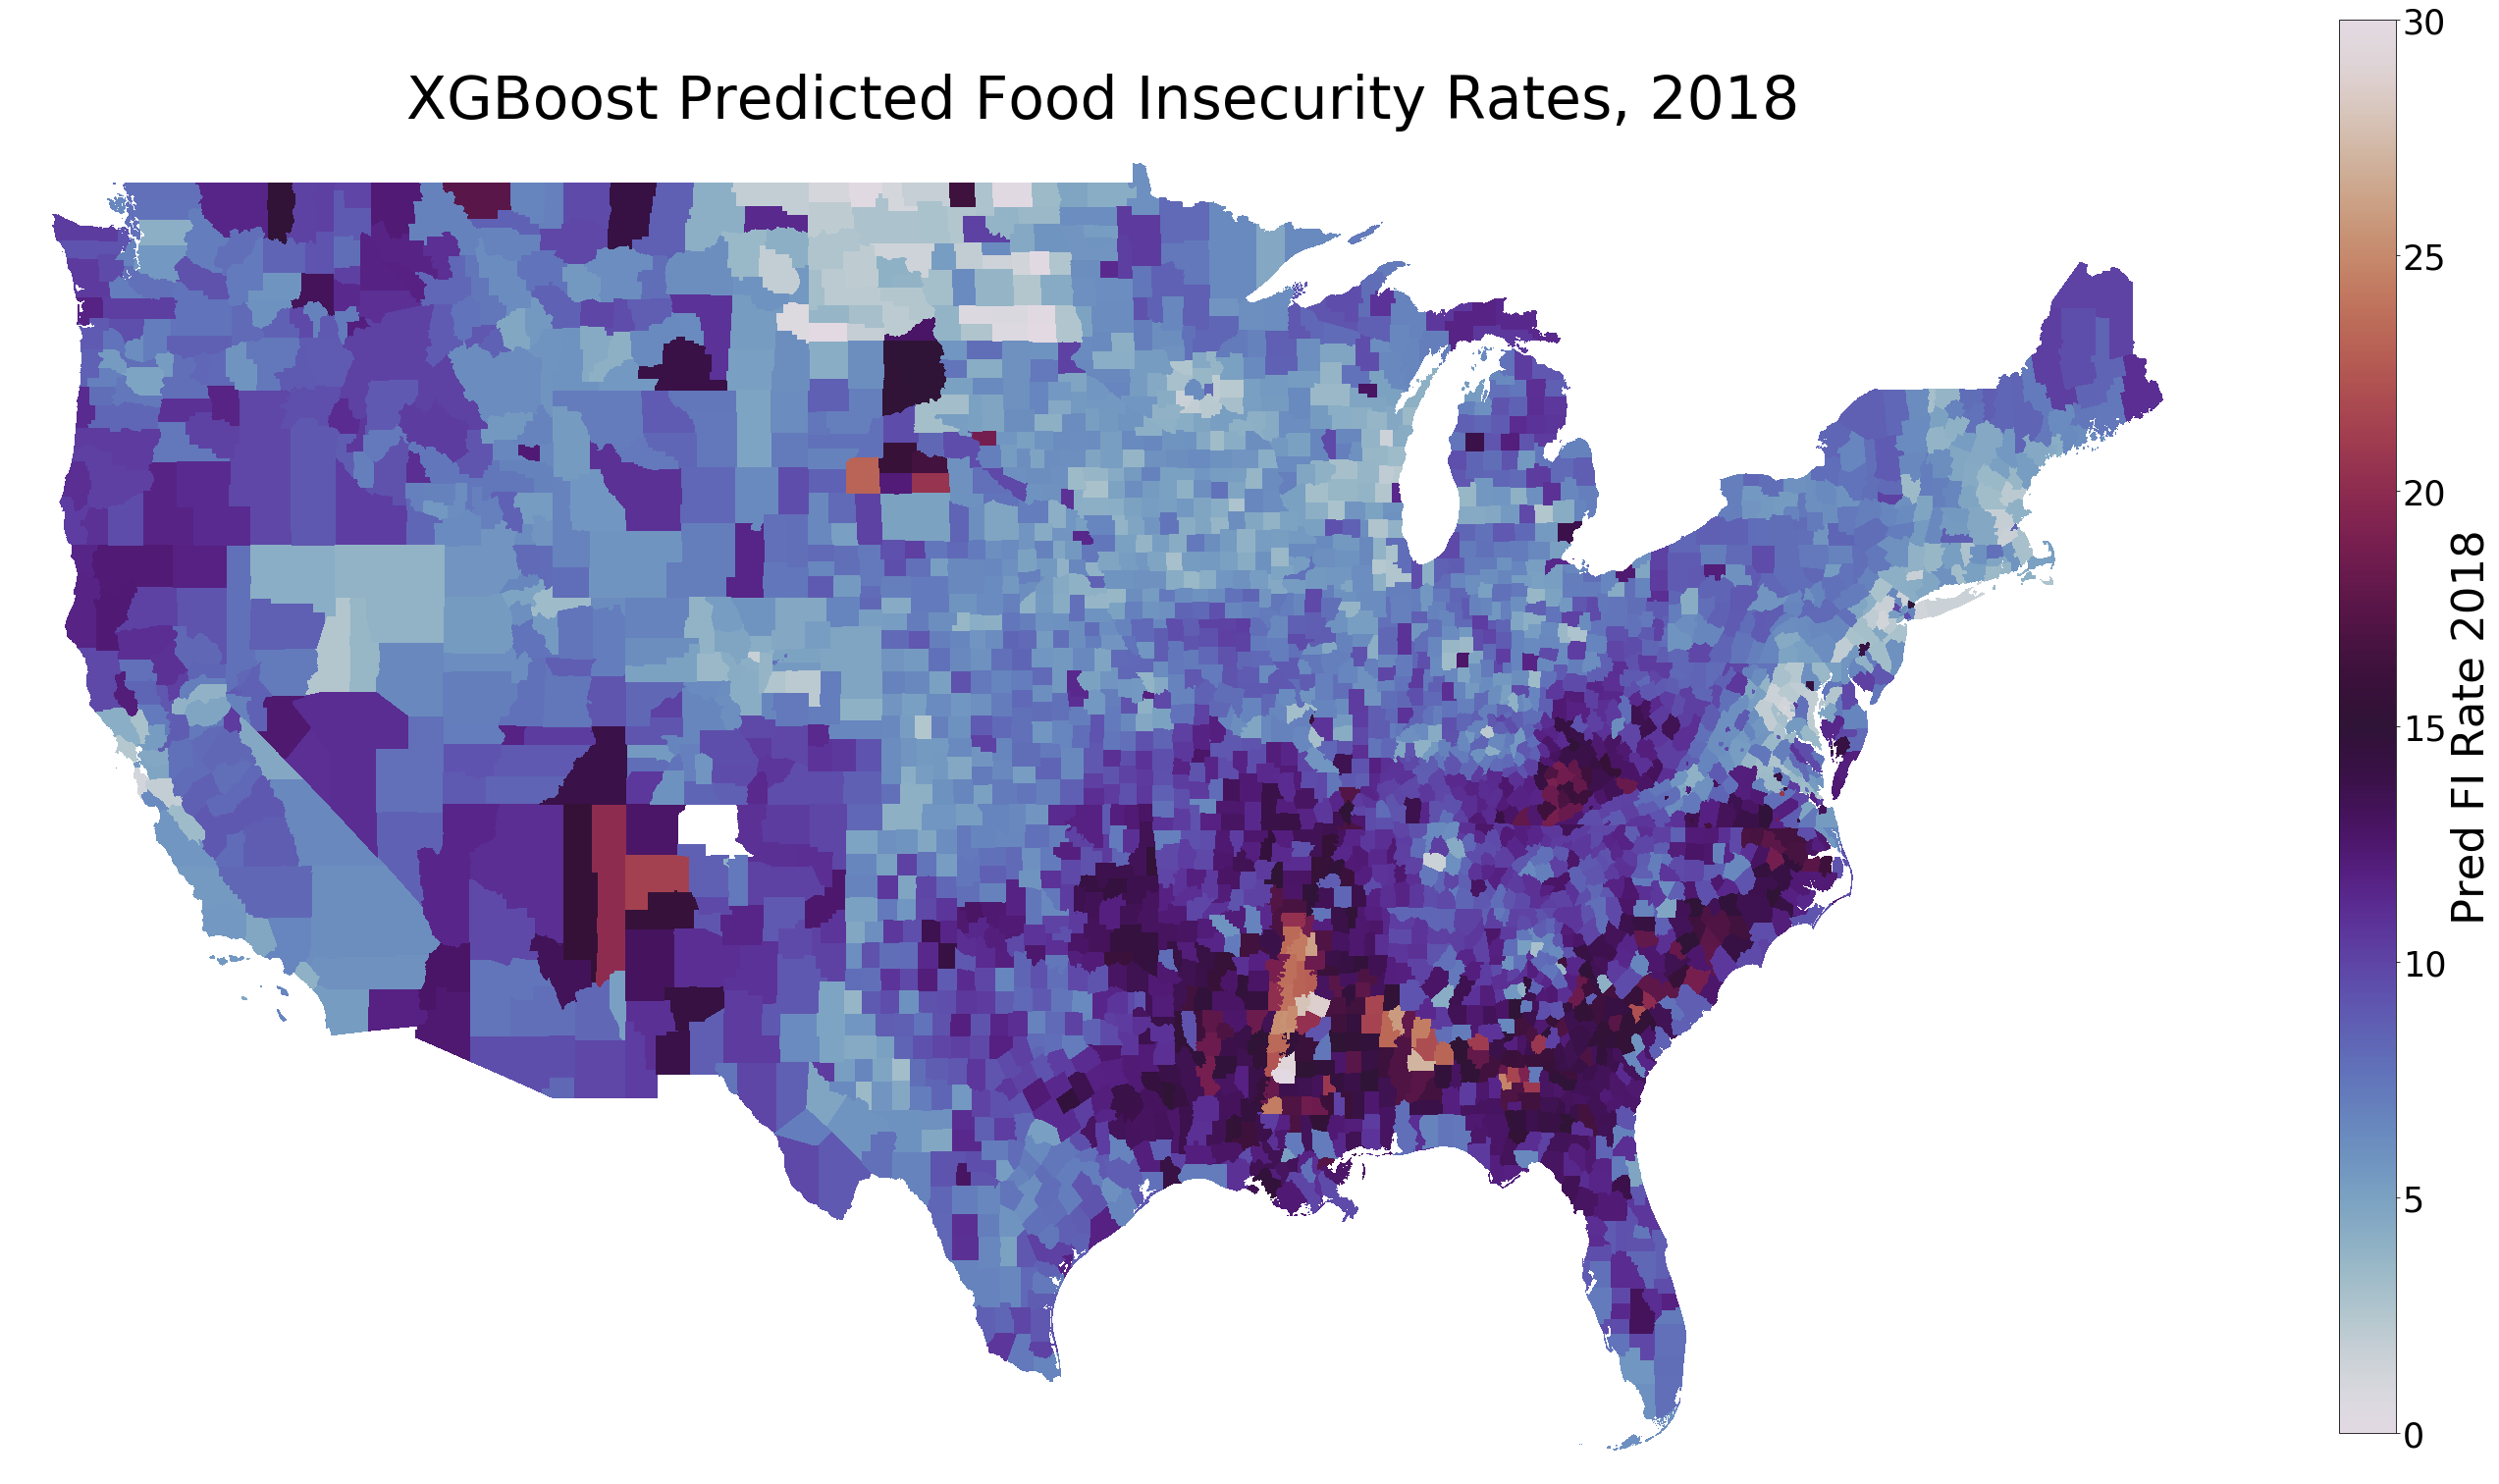

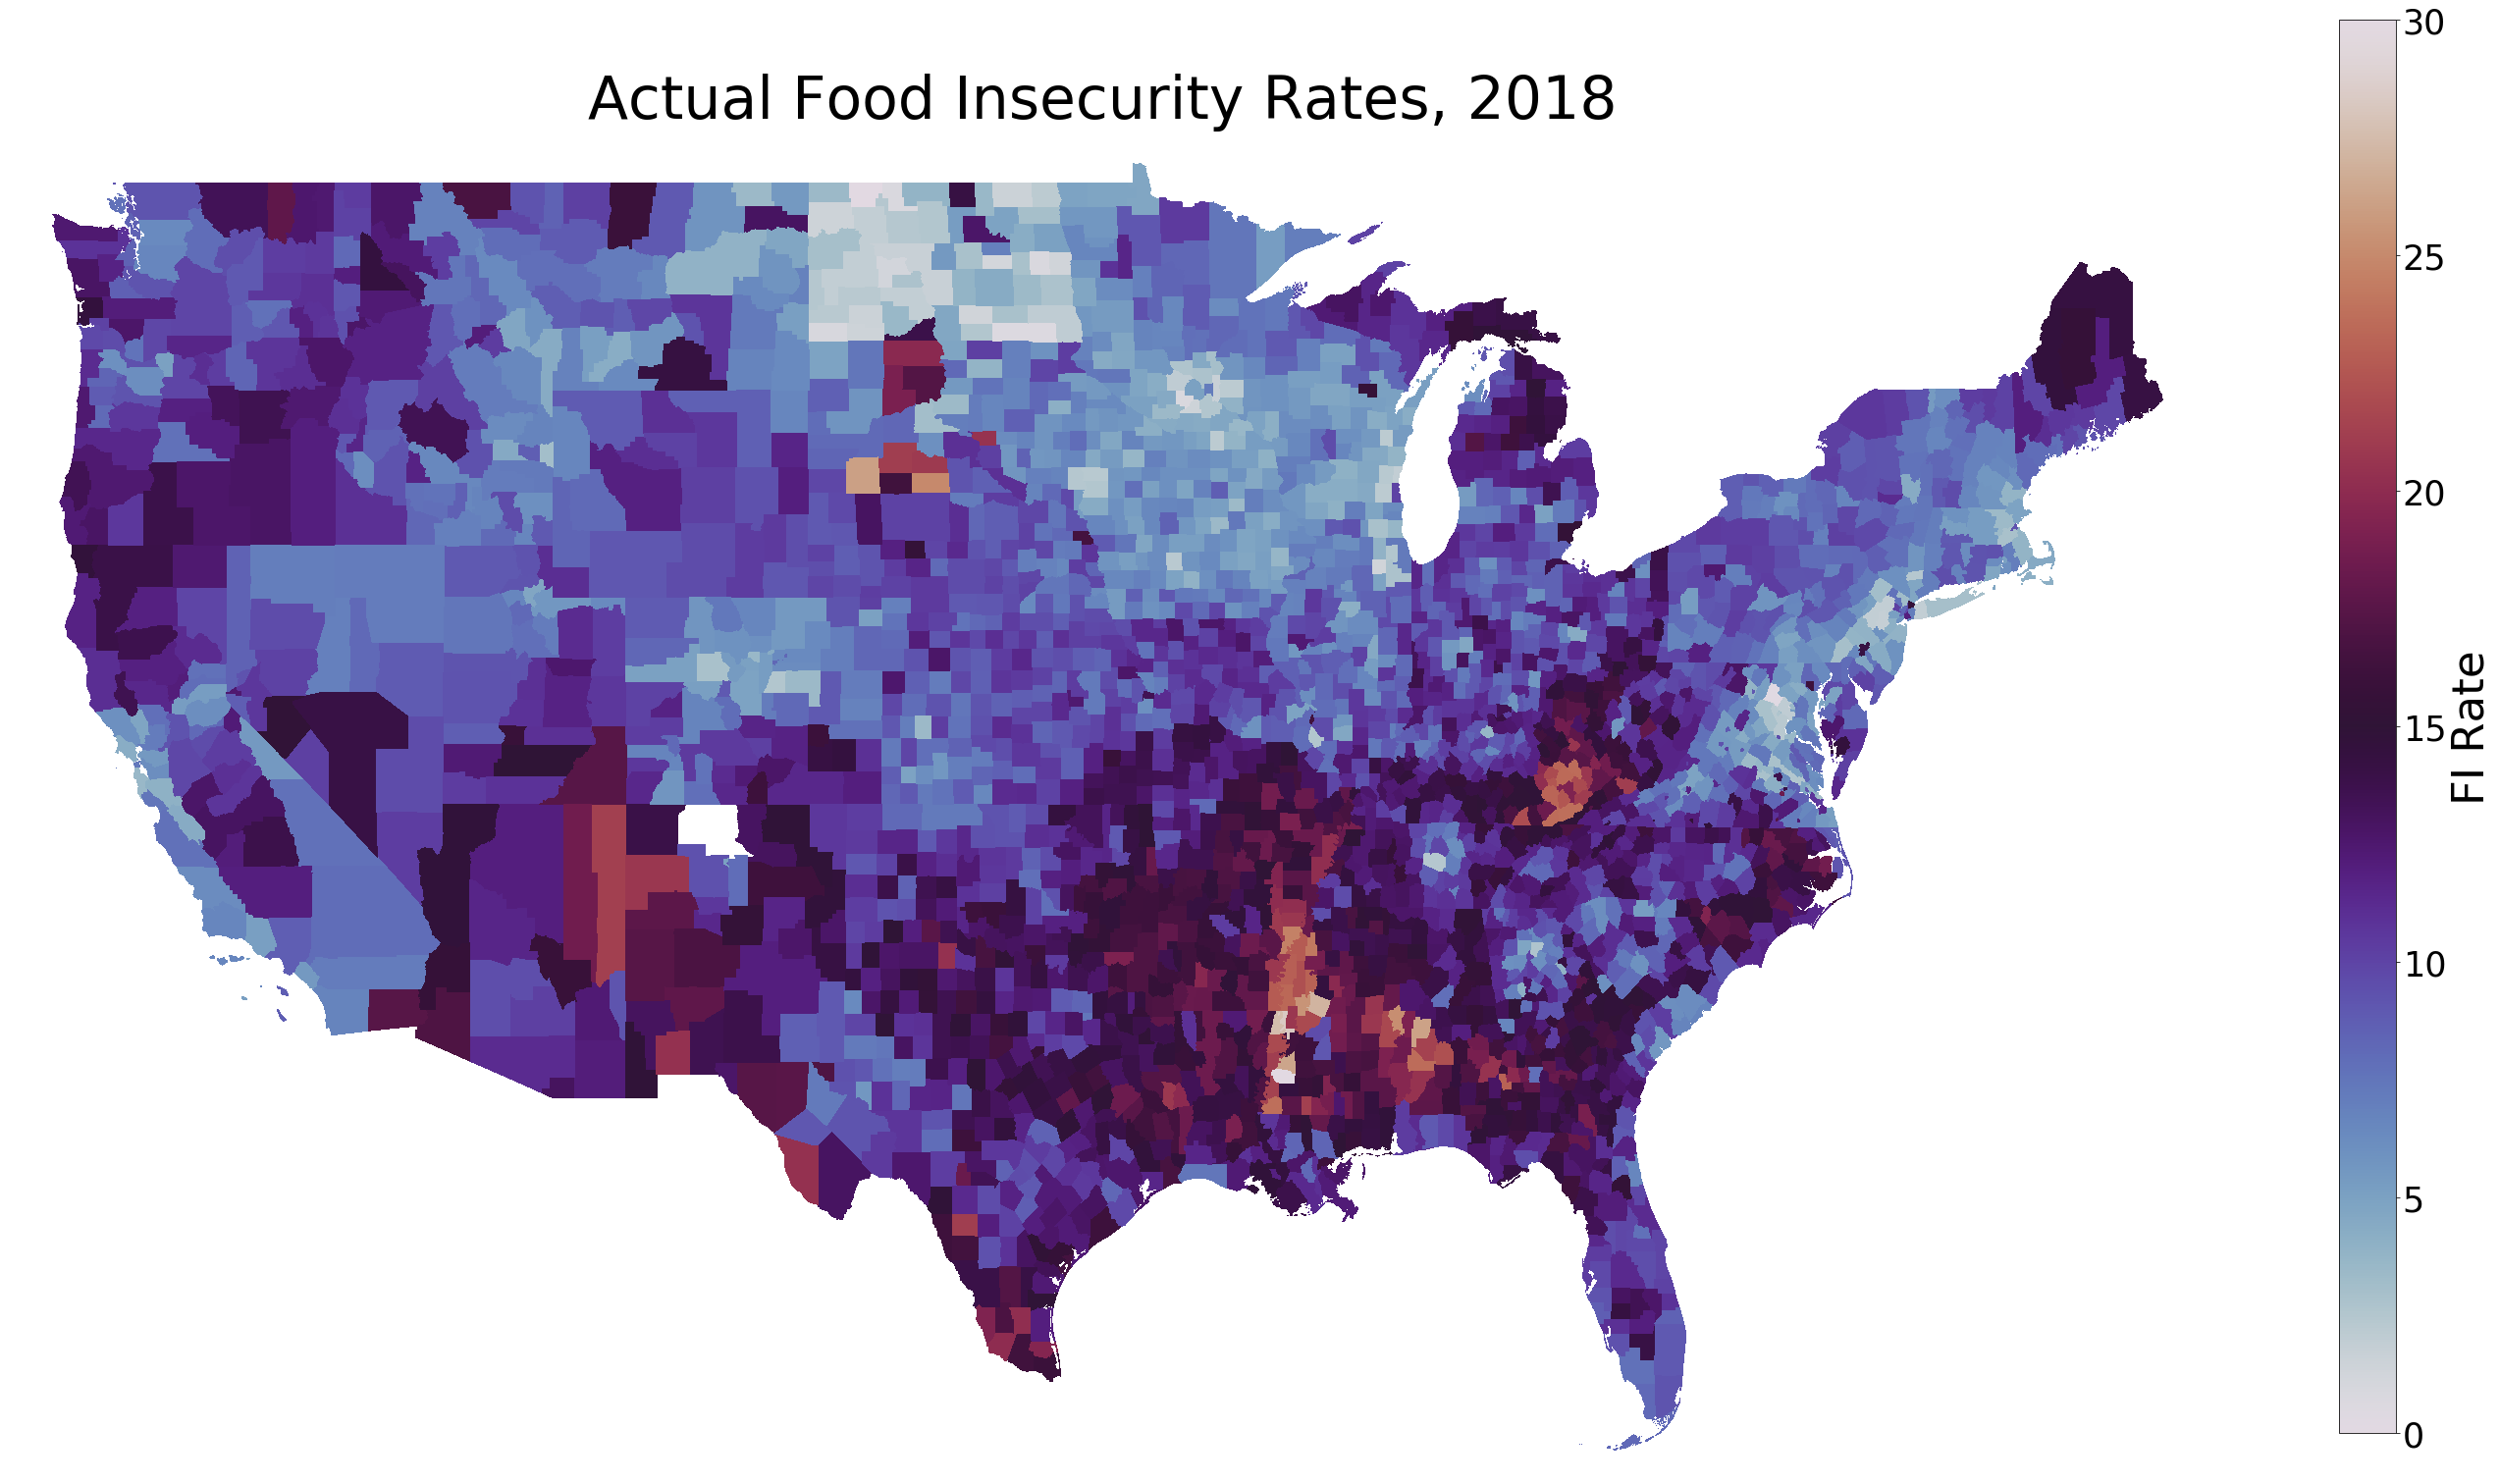

In [487]:
# XGBoost with polynomials and hs grad
choropleth(df_preds_20,'Pred FI Rate 2020','2020','twilight','XGBoost Food Insecurity Rates')
choropleth(df_preds_18,'Pred FI Rate 2018','2018','twilight','XGBoost Predicted Food Insecurity Rates')
choropleth(df_18,'FI Rate','2018','twilight', 'Actual Food Insecurity Rates')

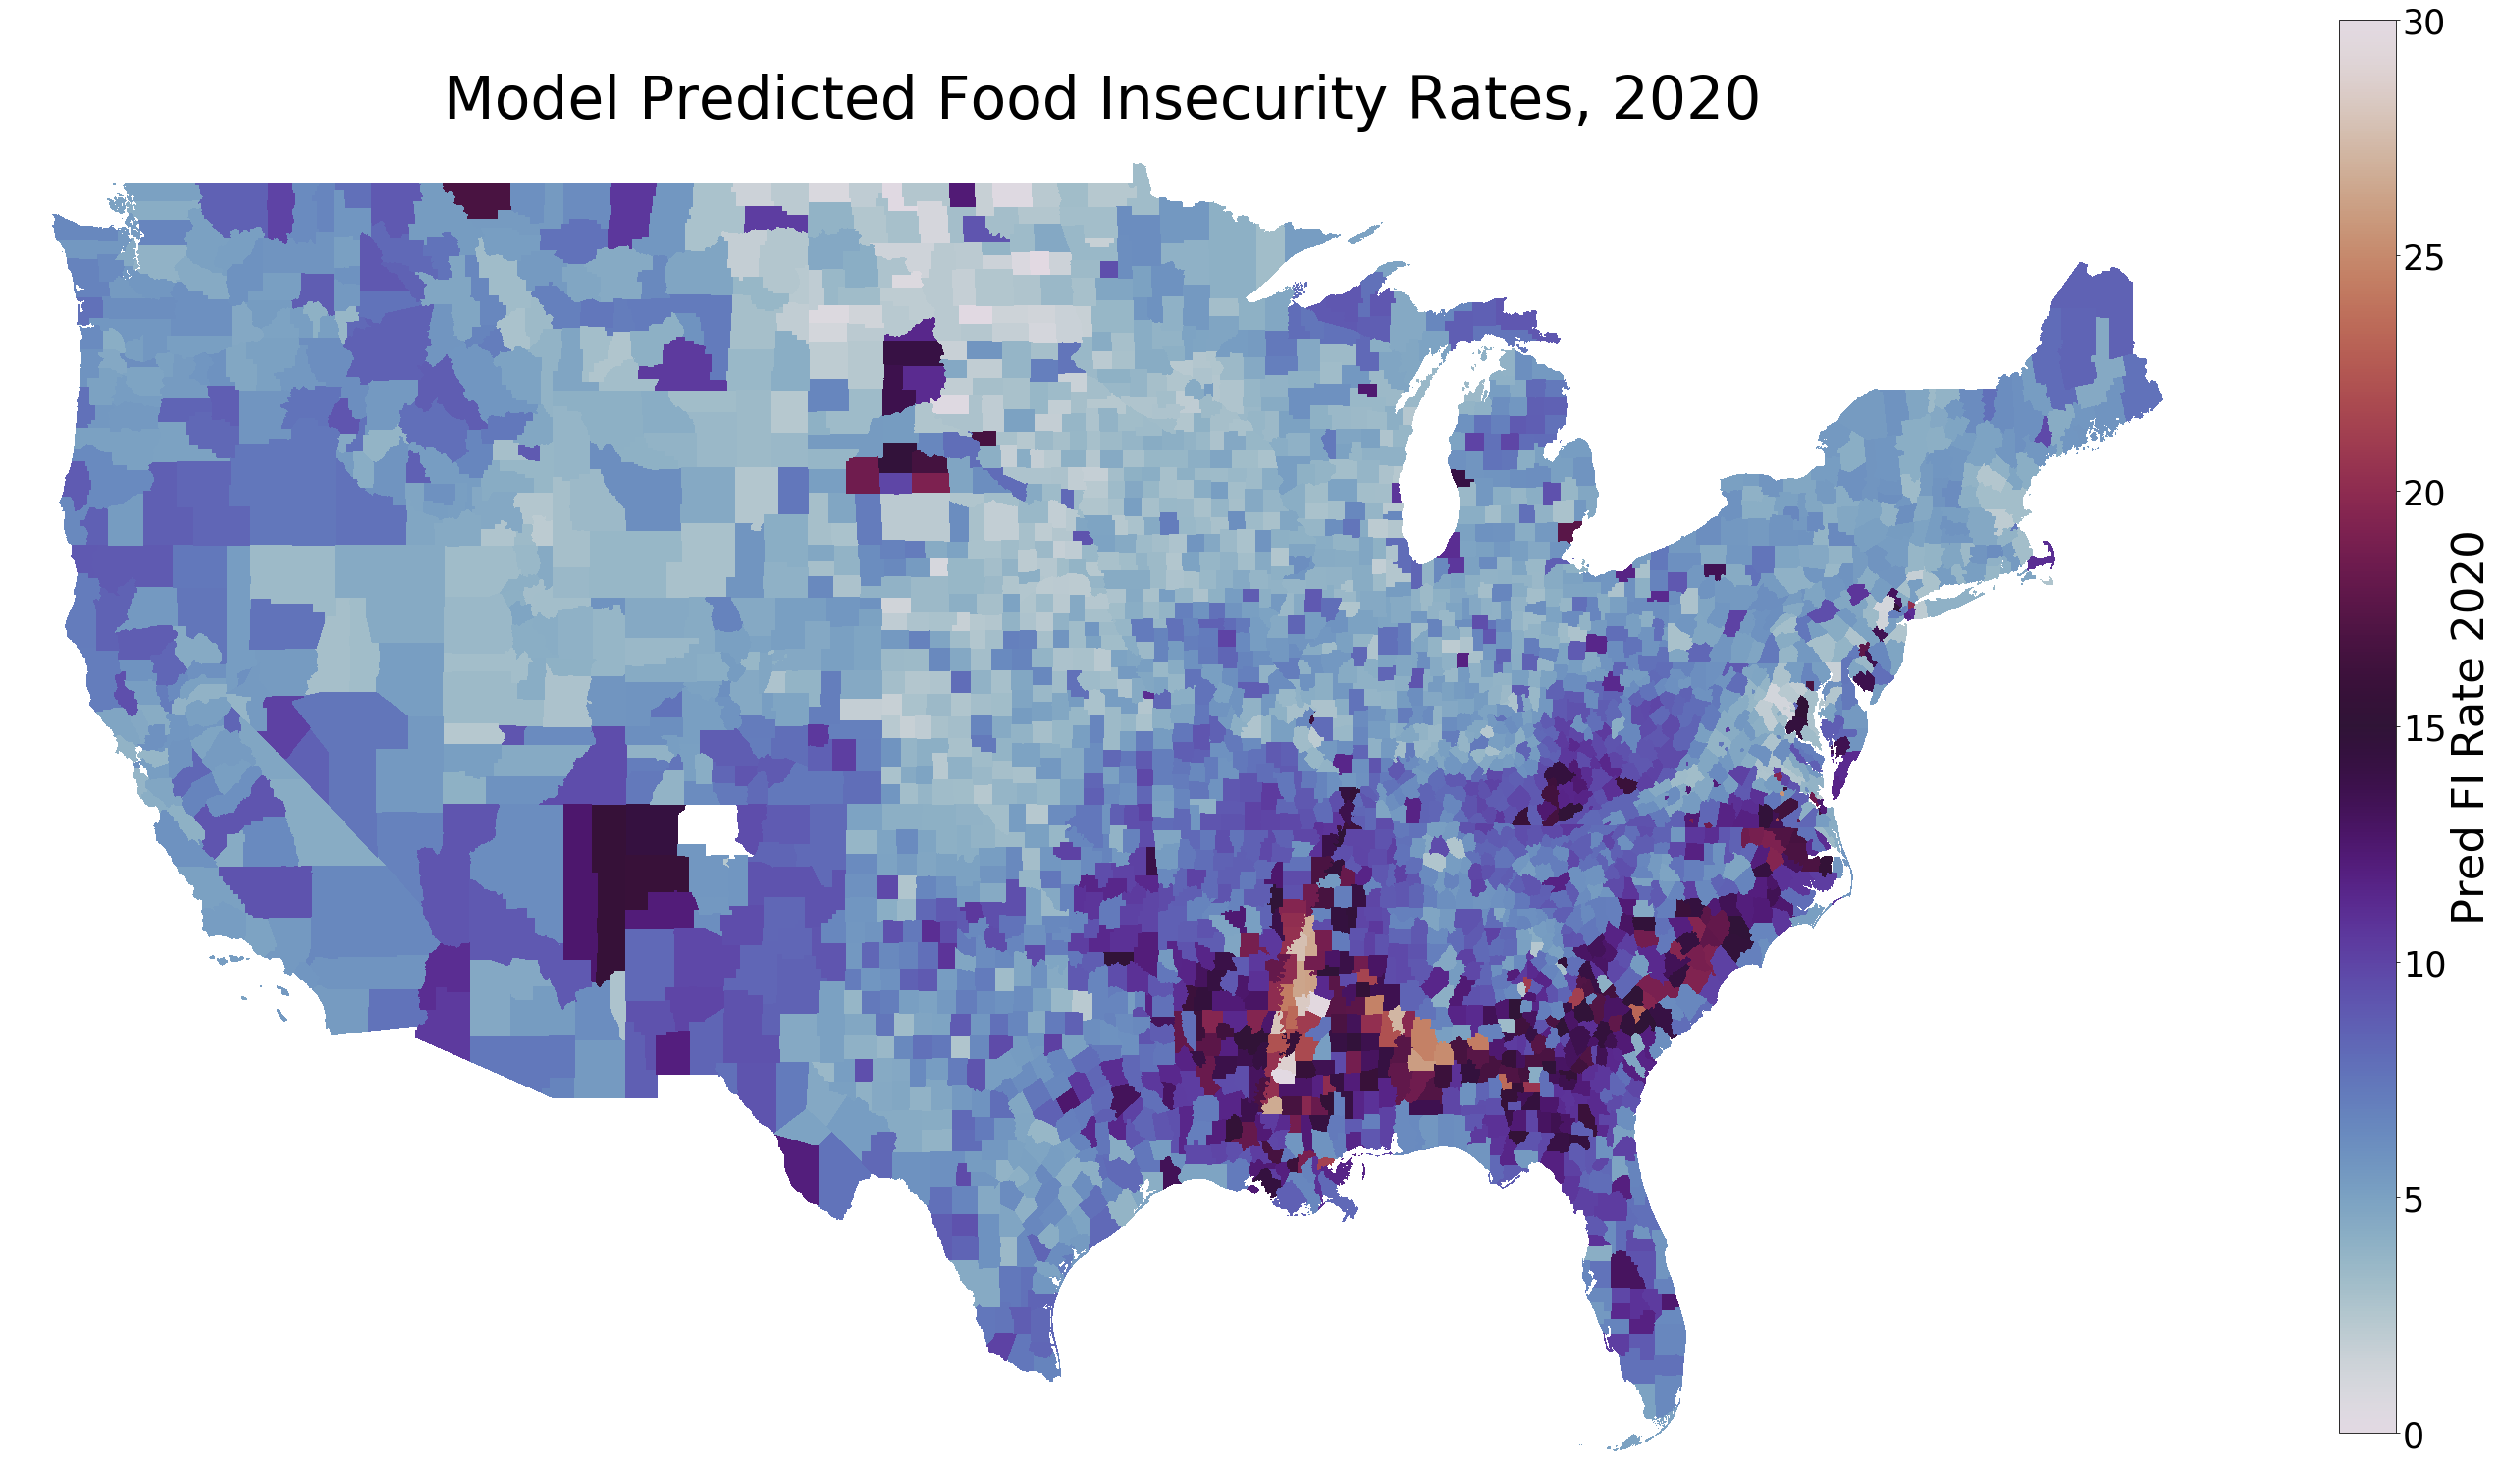

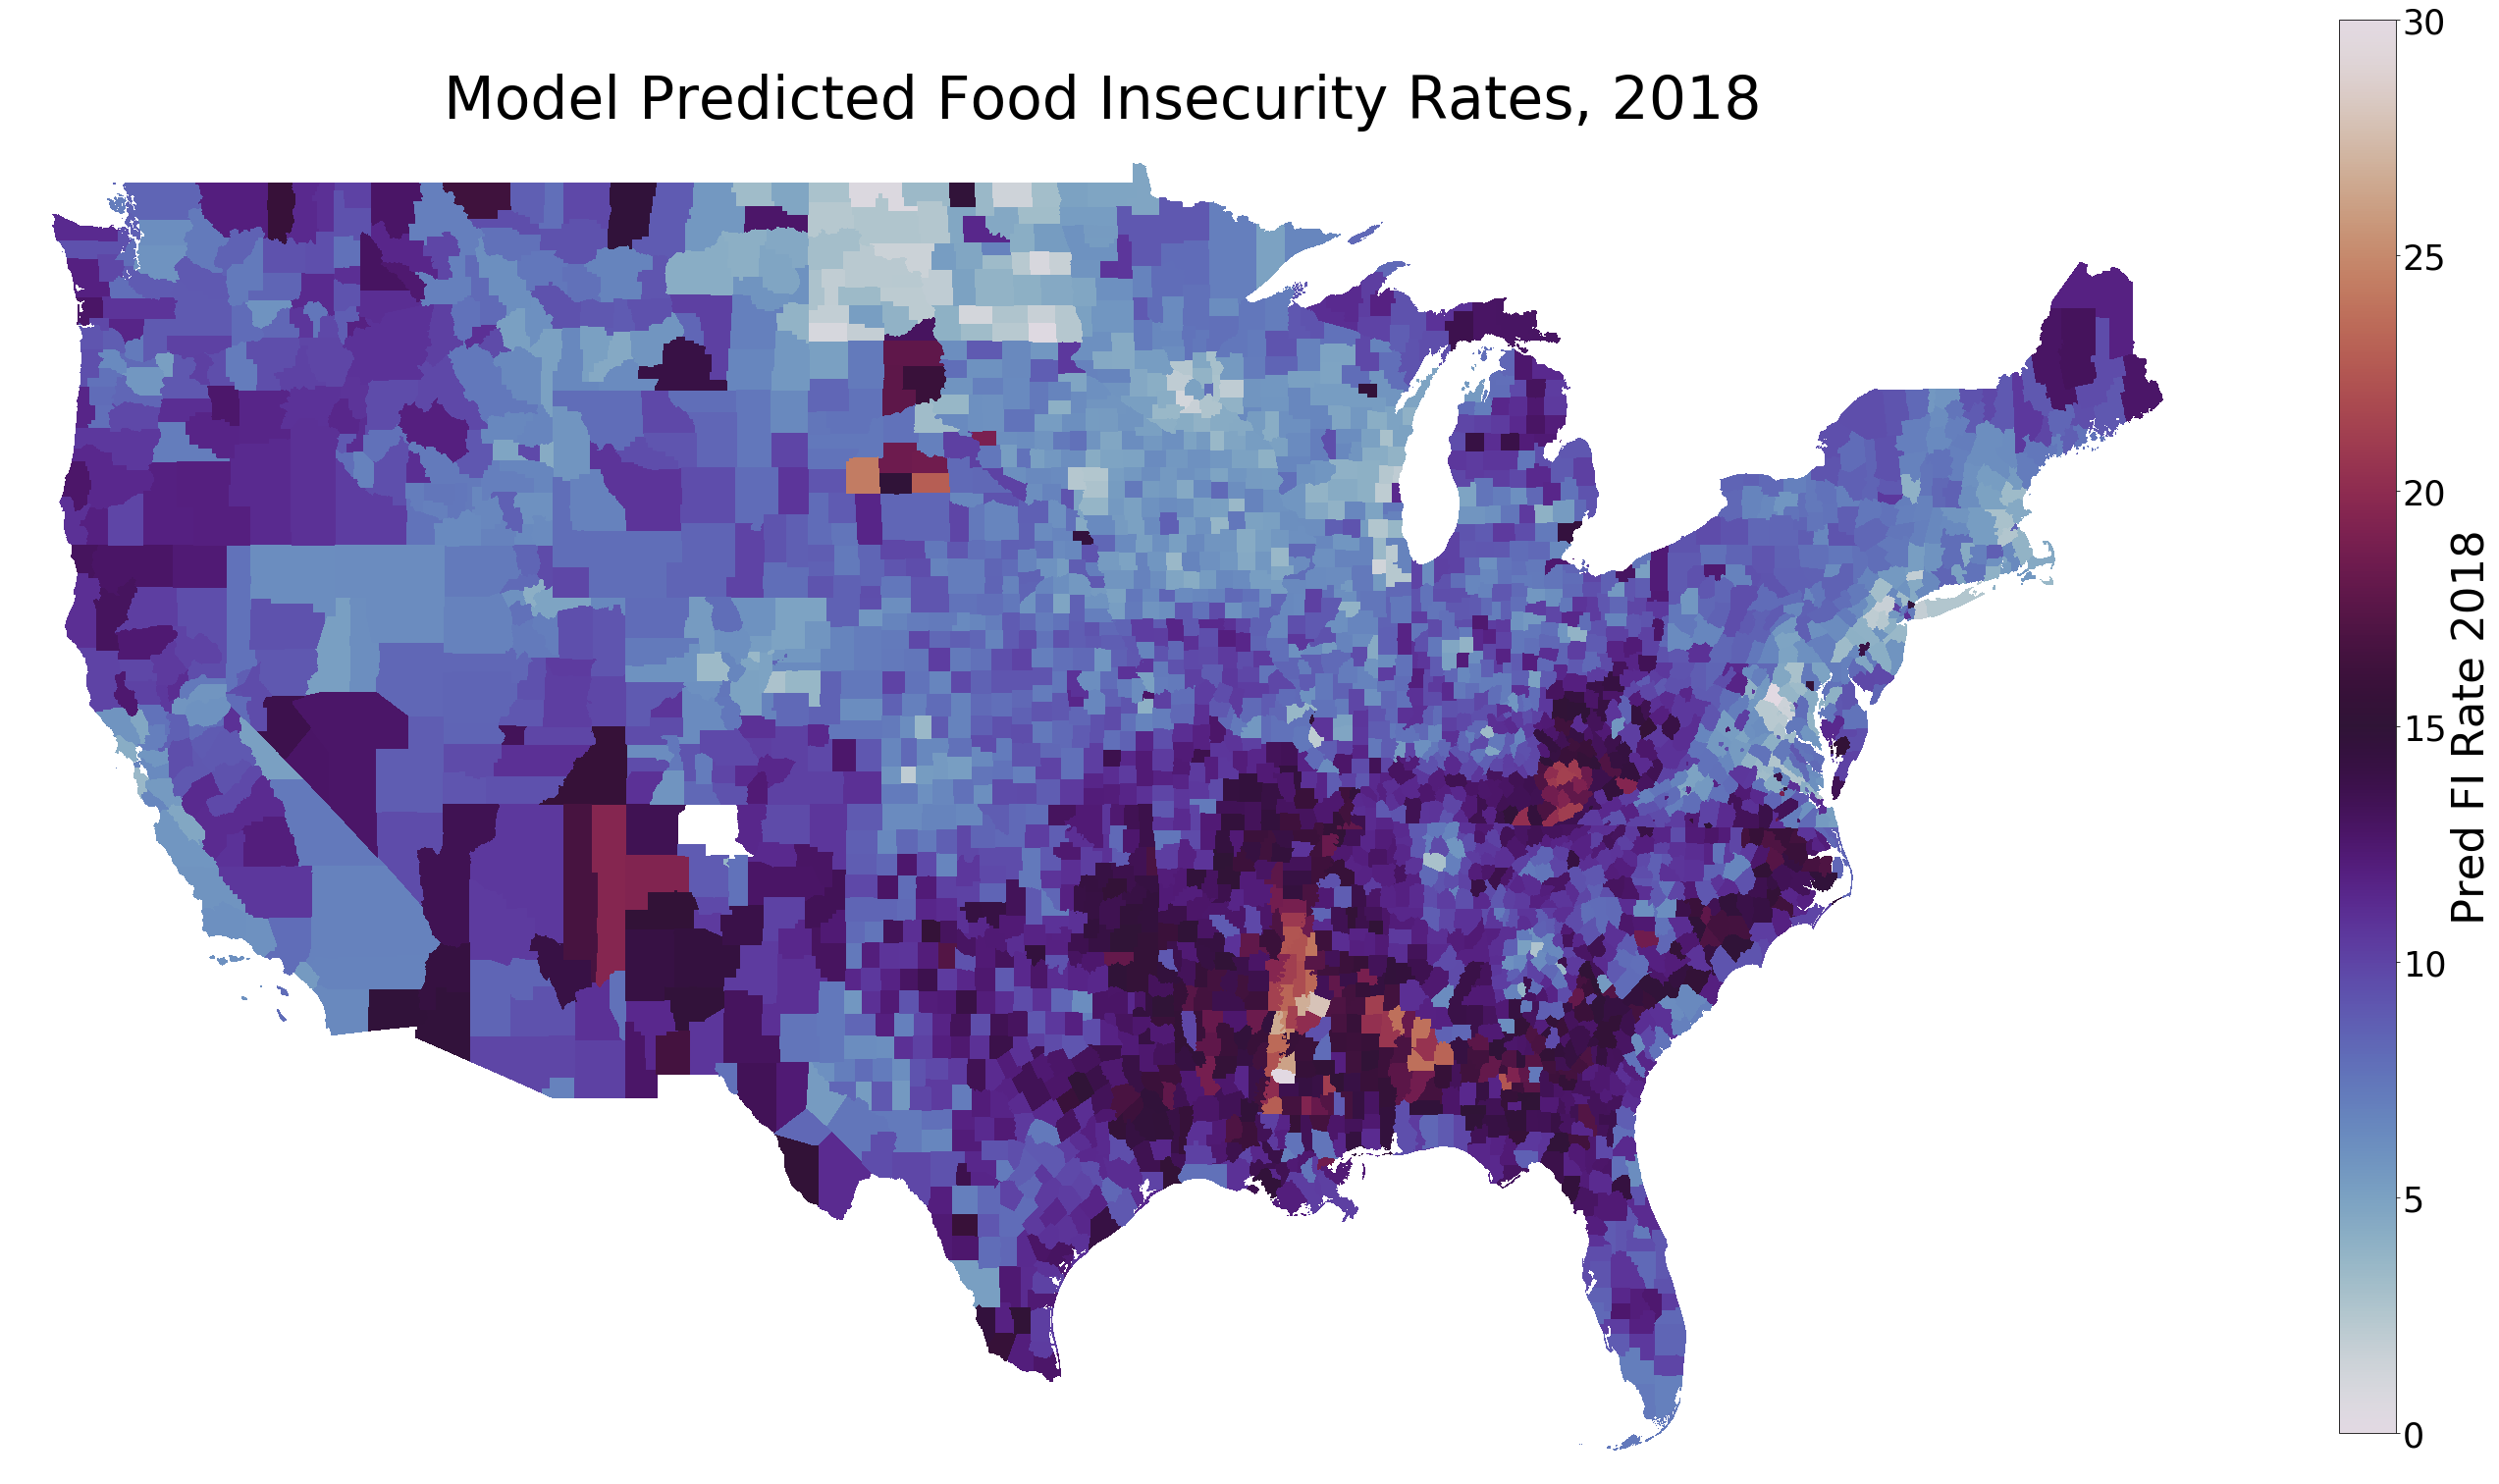

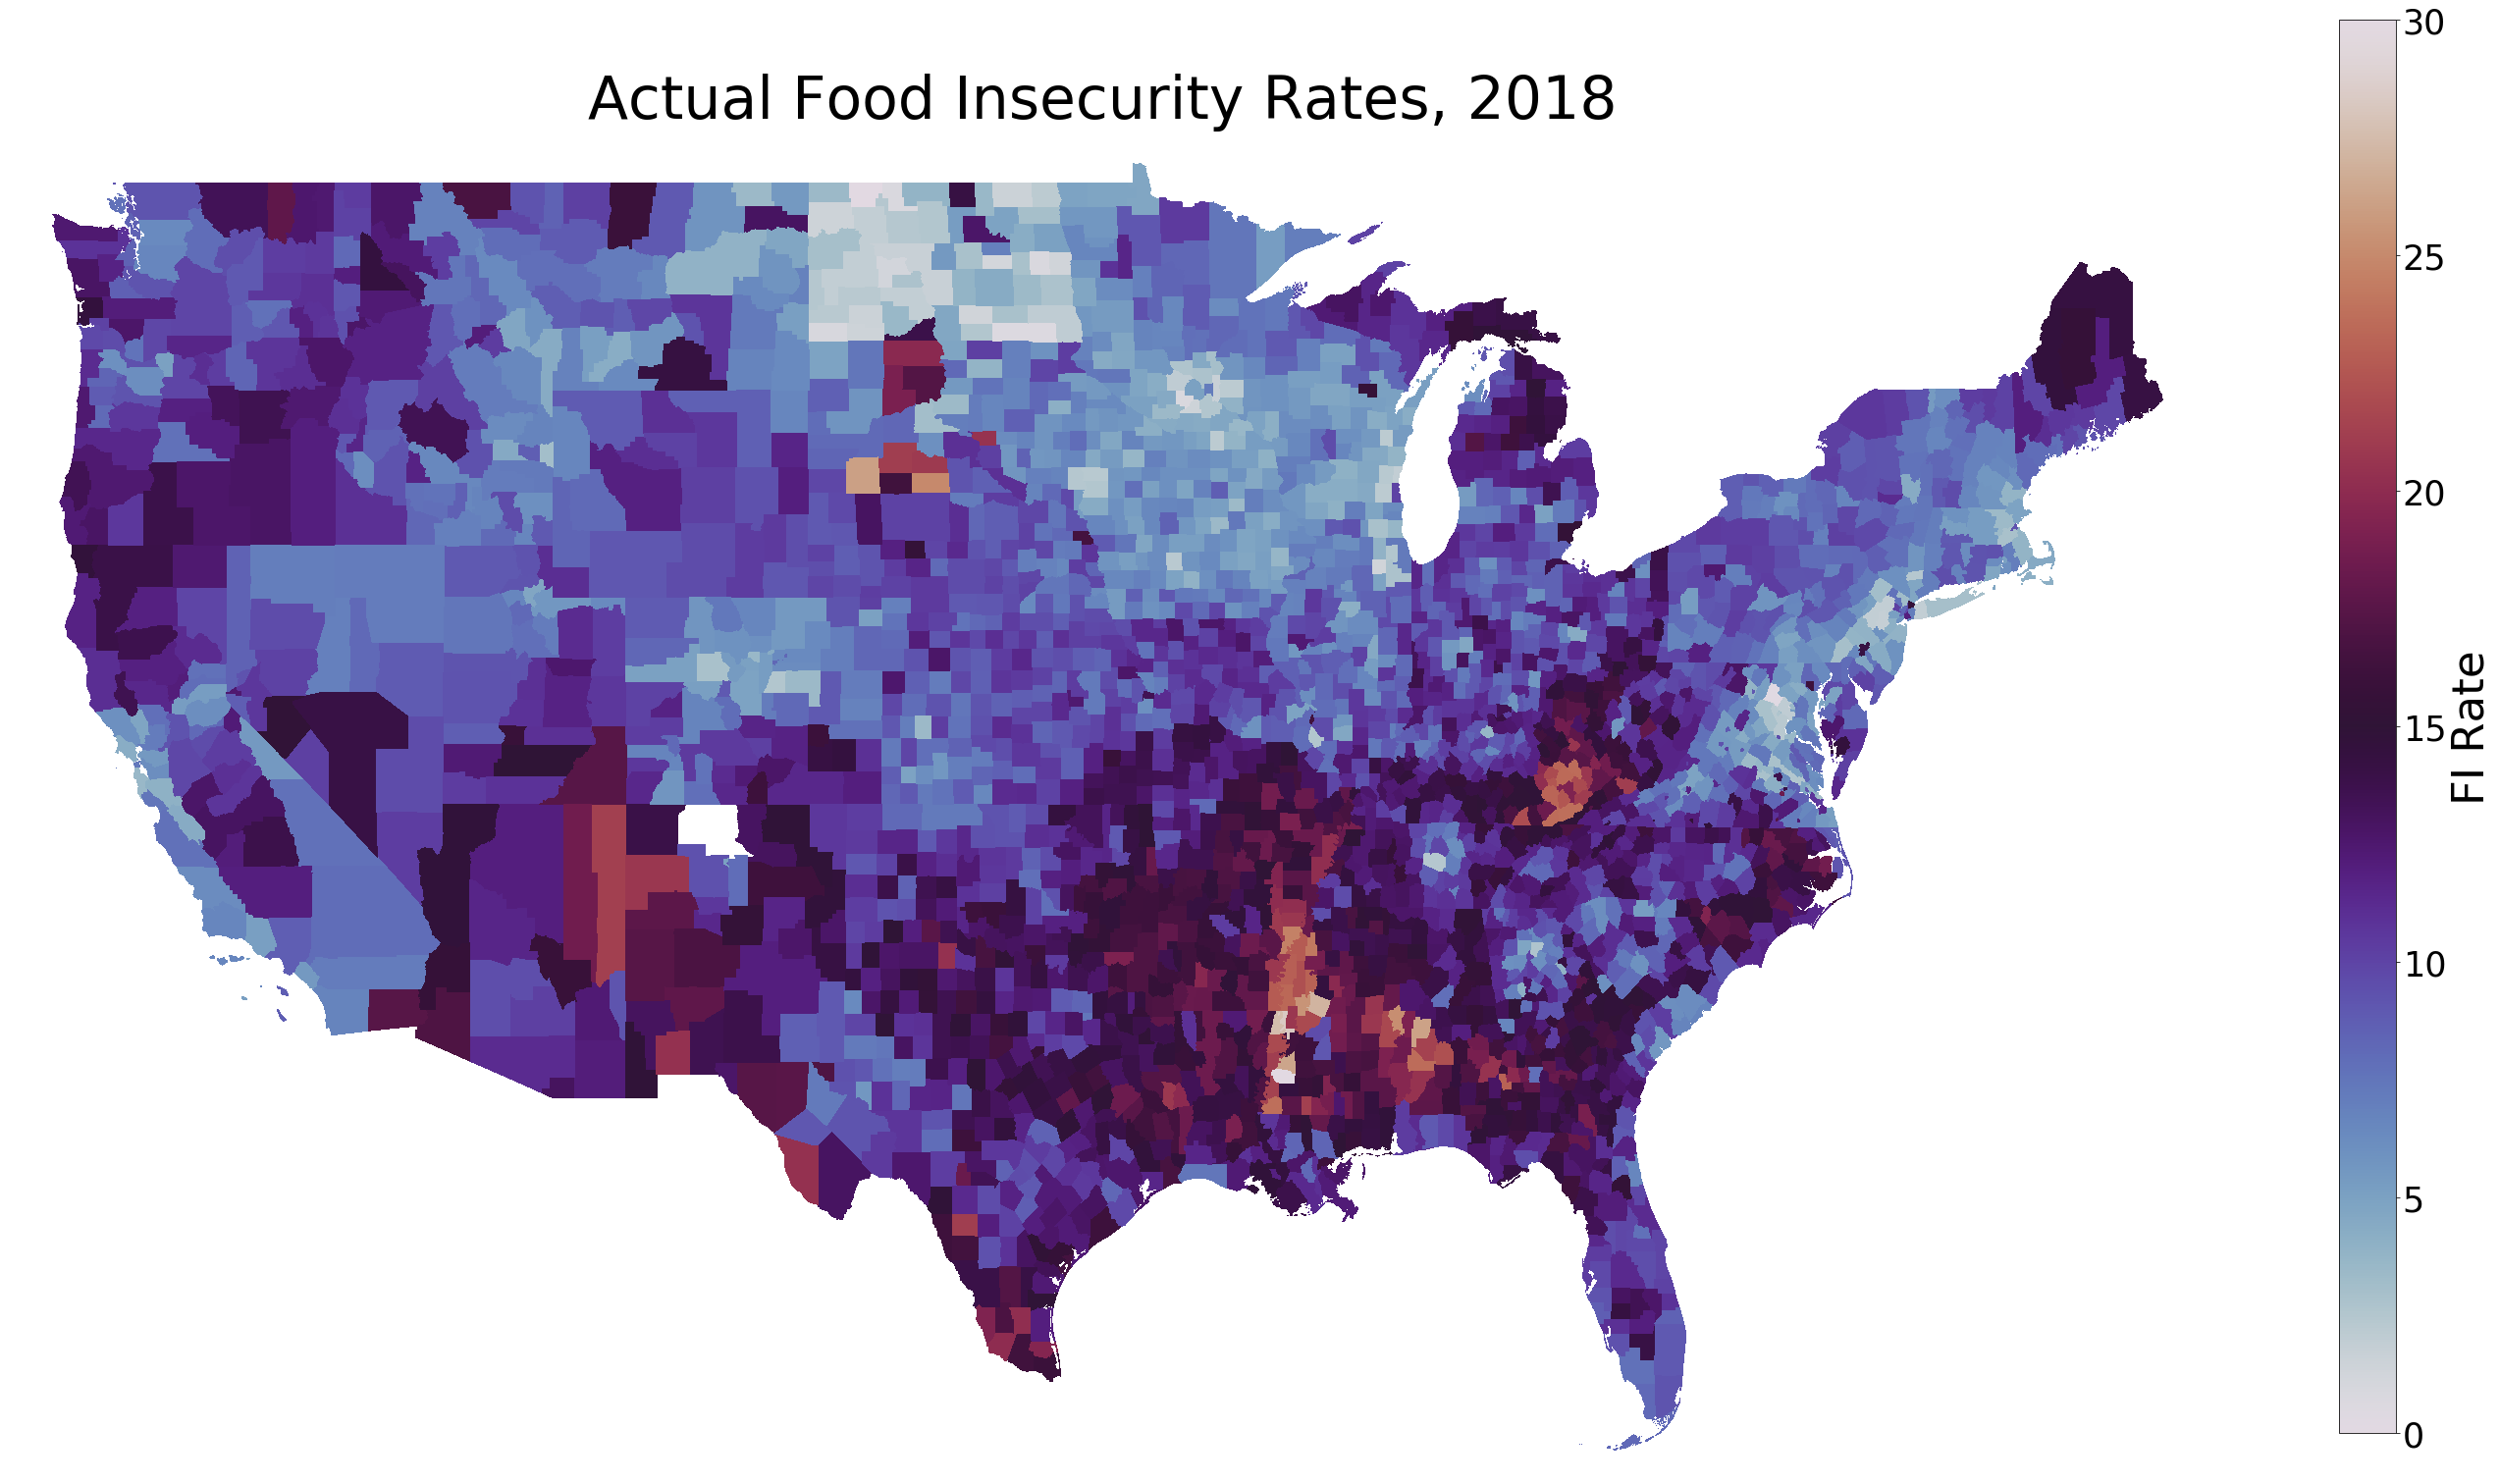

In [454]:
# random forest with polynomials, with hs grad
choropleth(df_preds_20,'Pred FI Rate 2020','2020','twilight','Model Predicted Food Insecurity Rates')
choropleth(df_preds_18,'Pred FI Rate 2018','2018','twilight','Model Predicted Food Insecurity Rates')
choropleth(df_18,'FI Rate','2018','twilight', 'Actual Food Insecurity Rates')

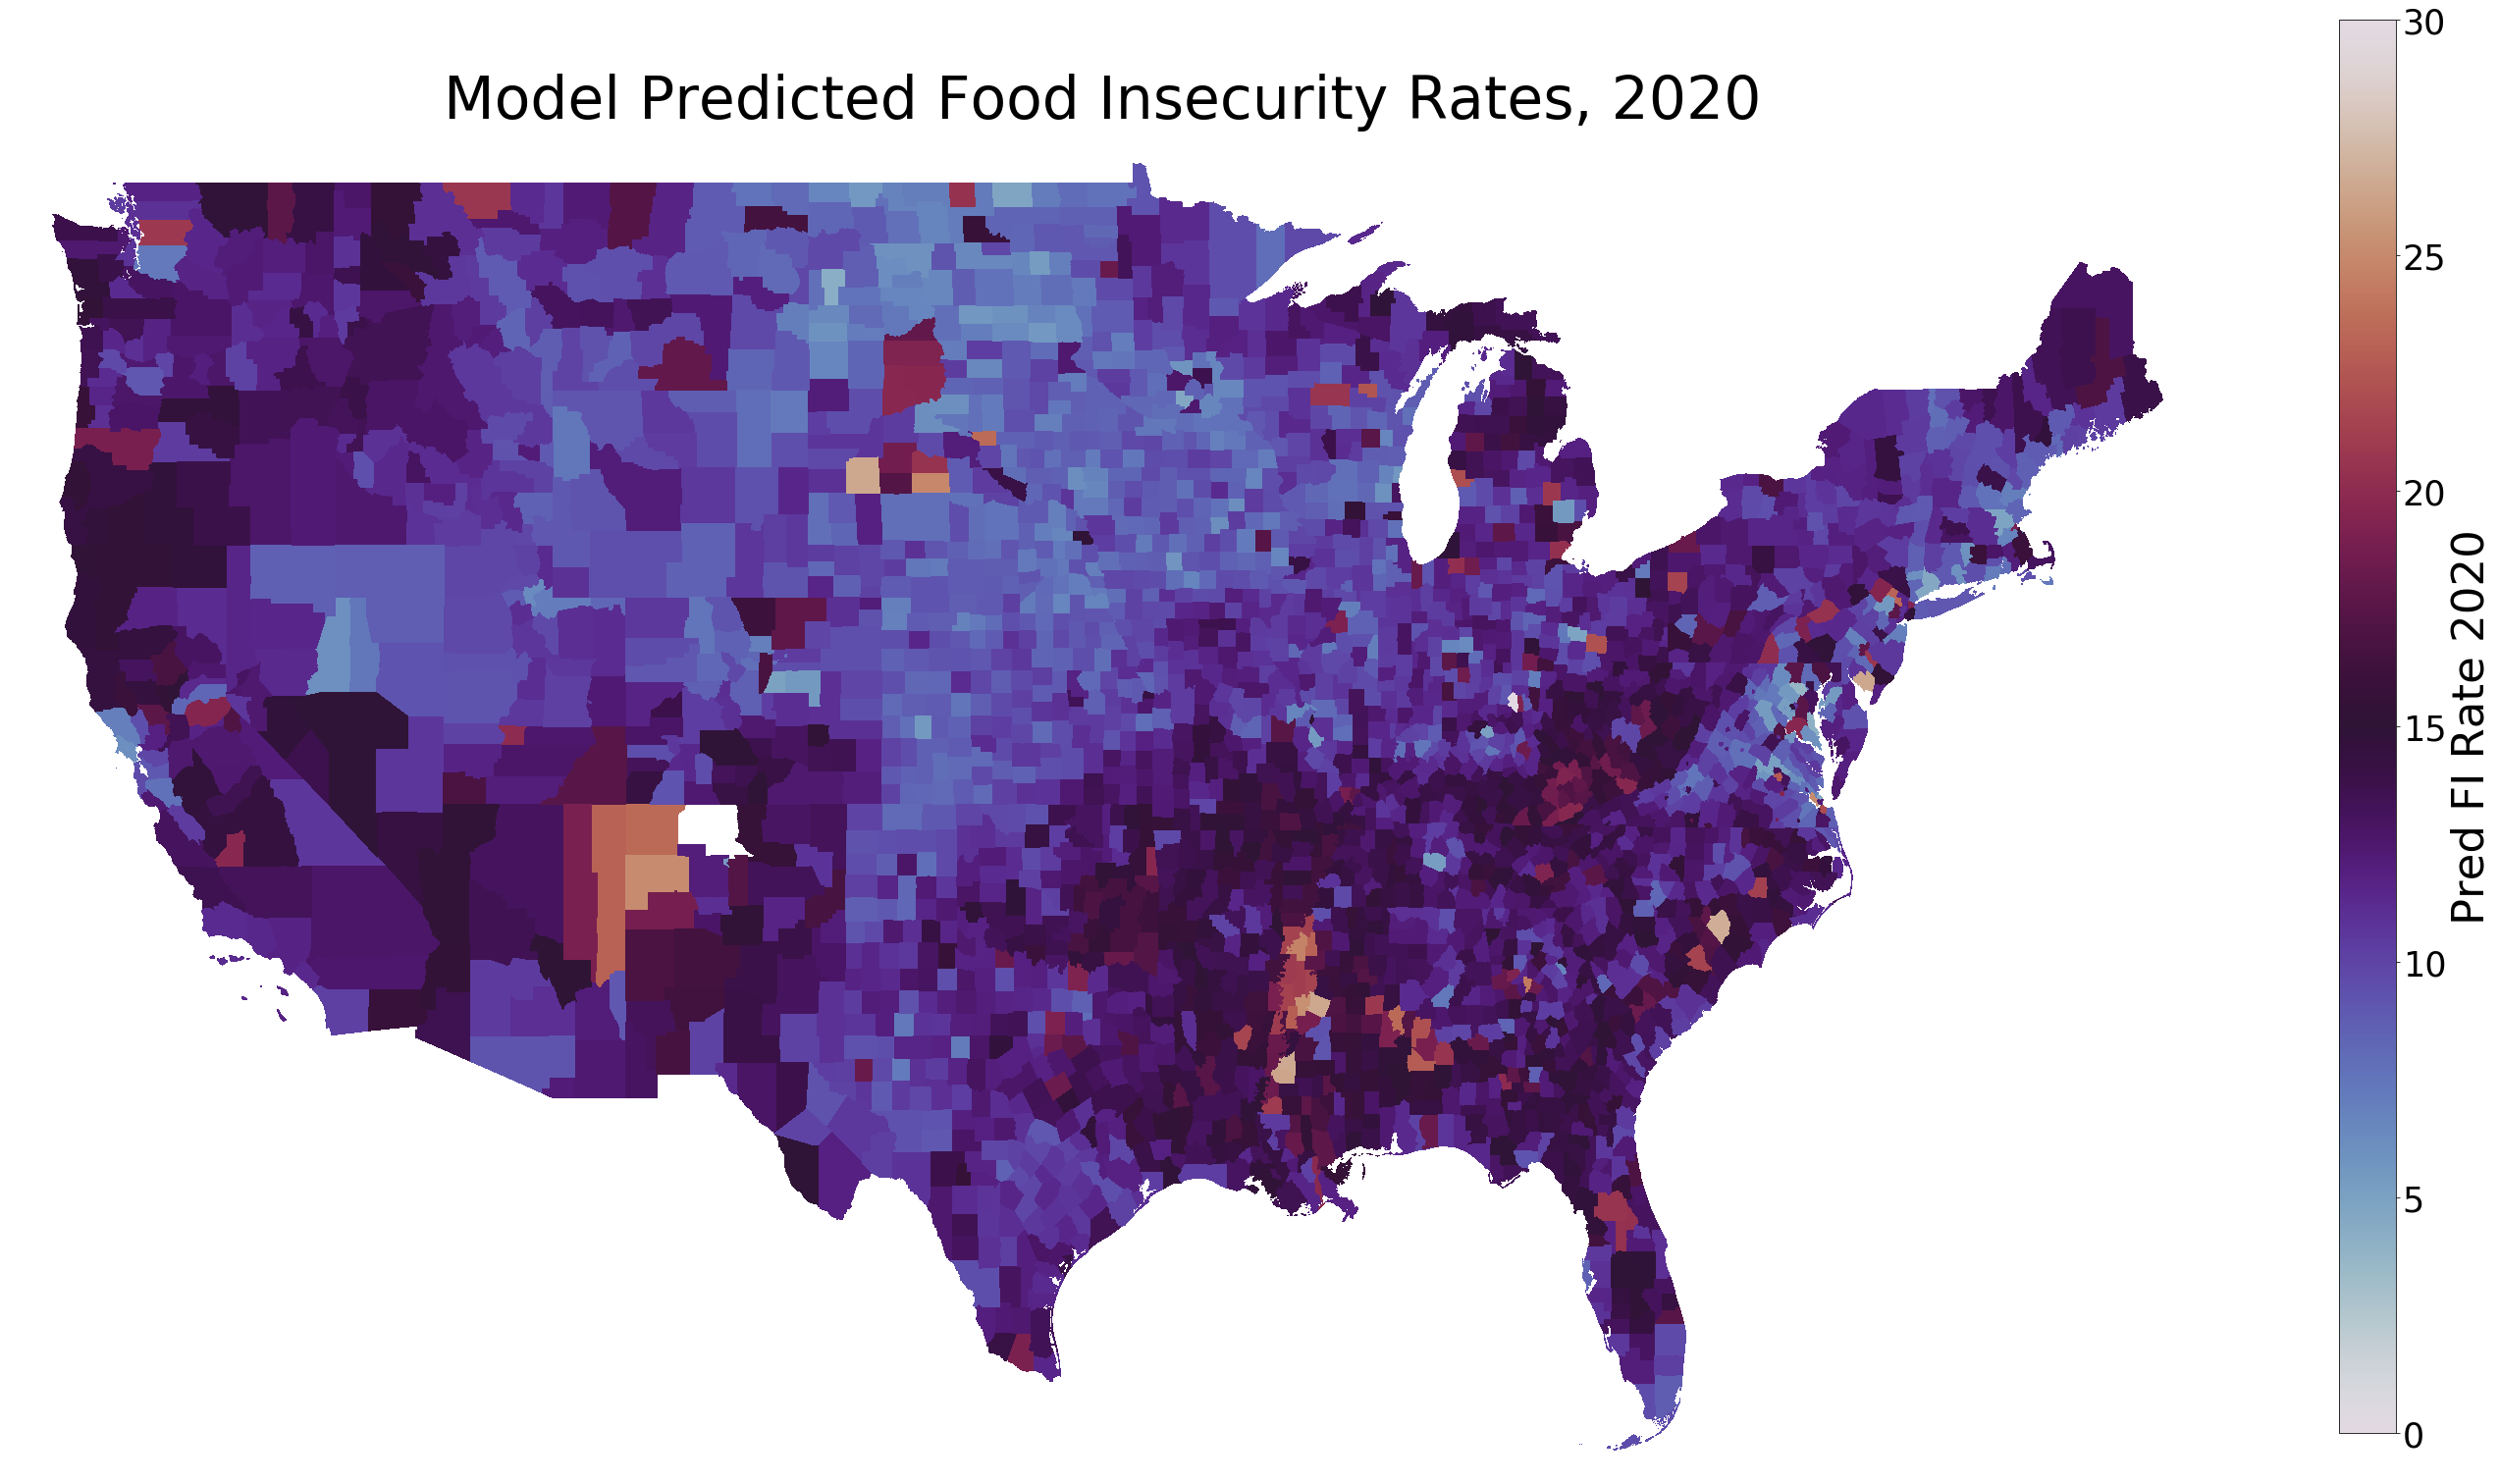

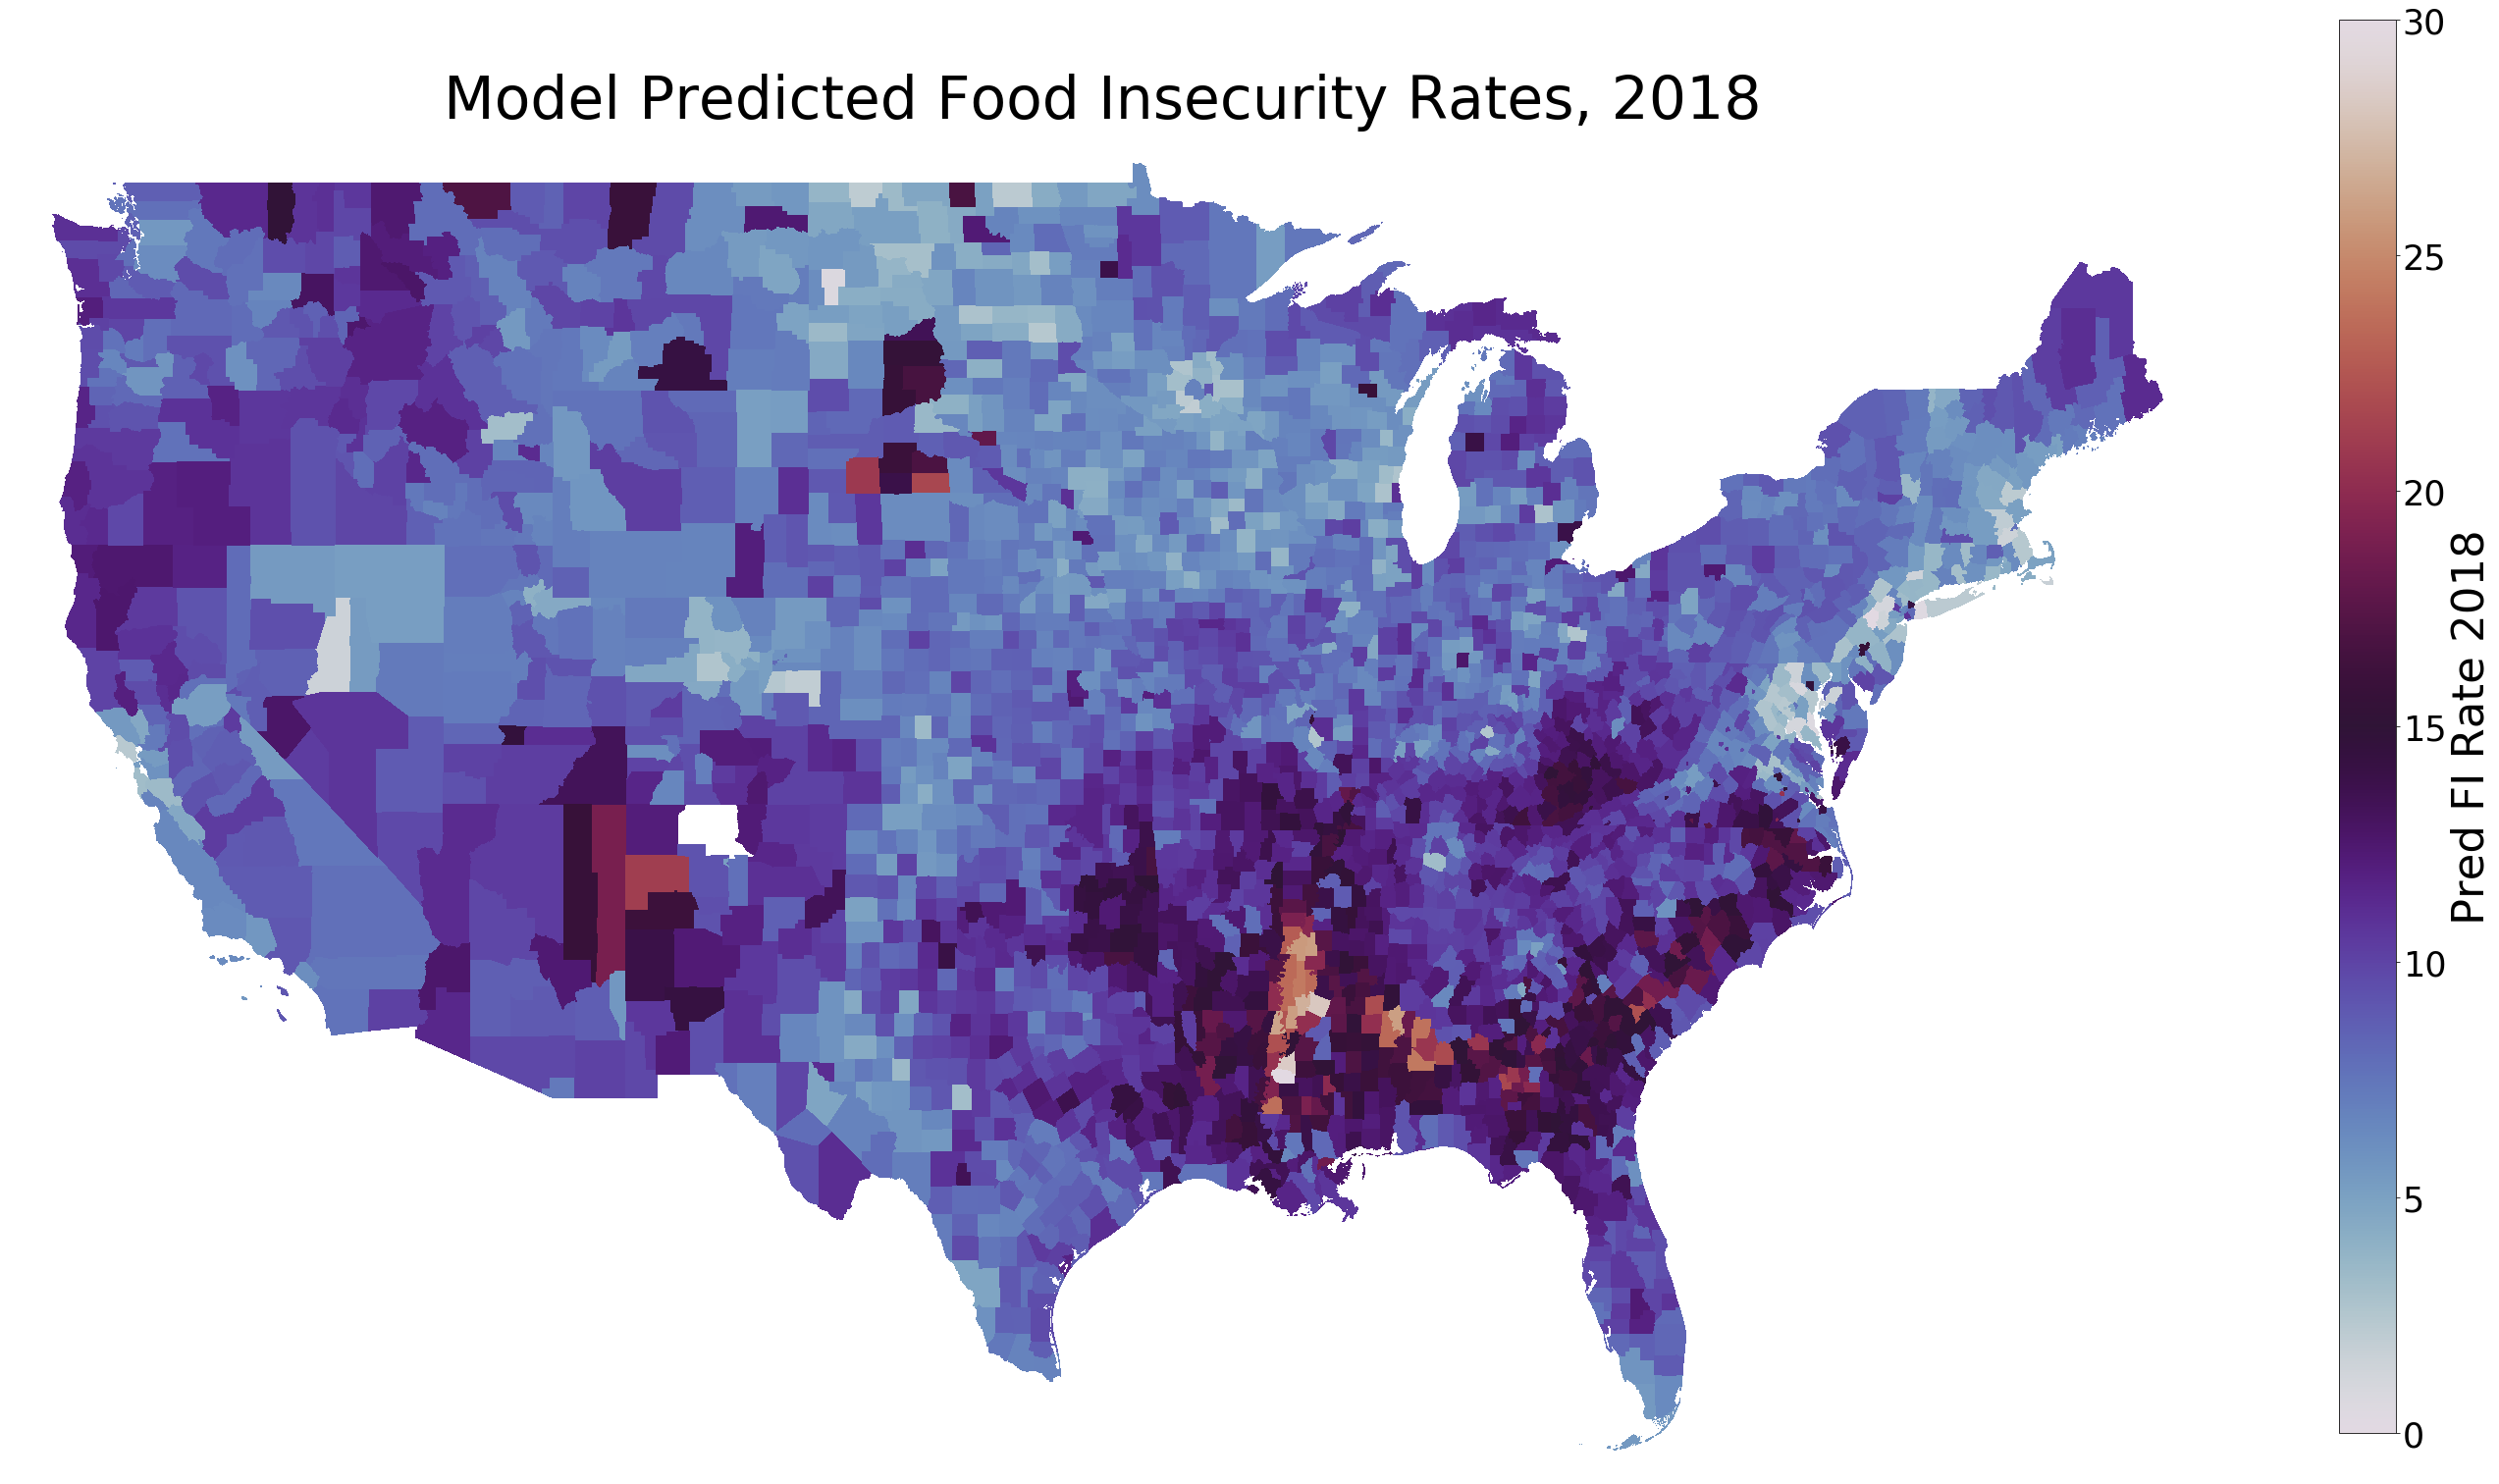

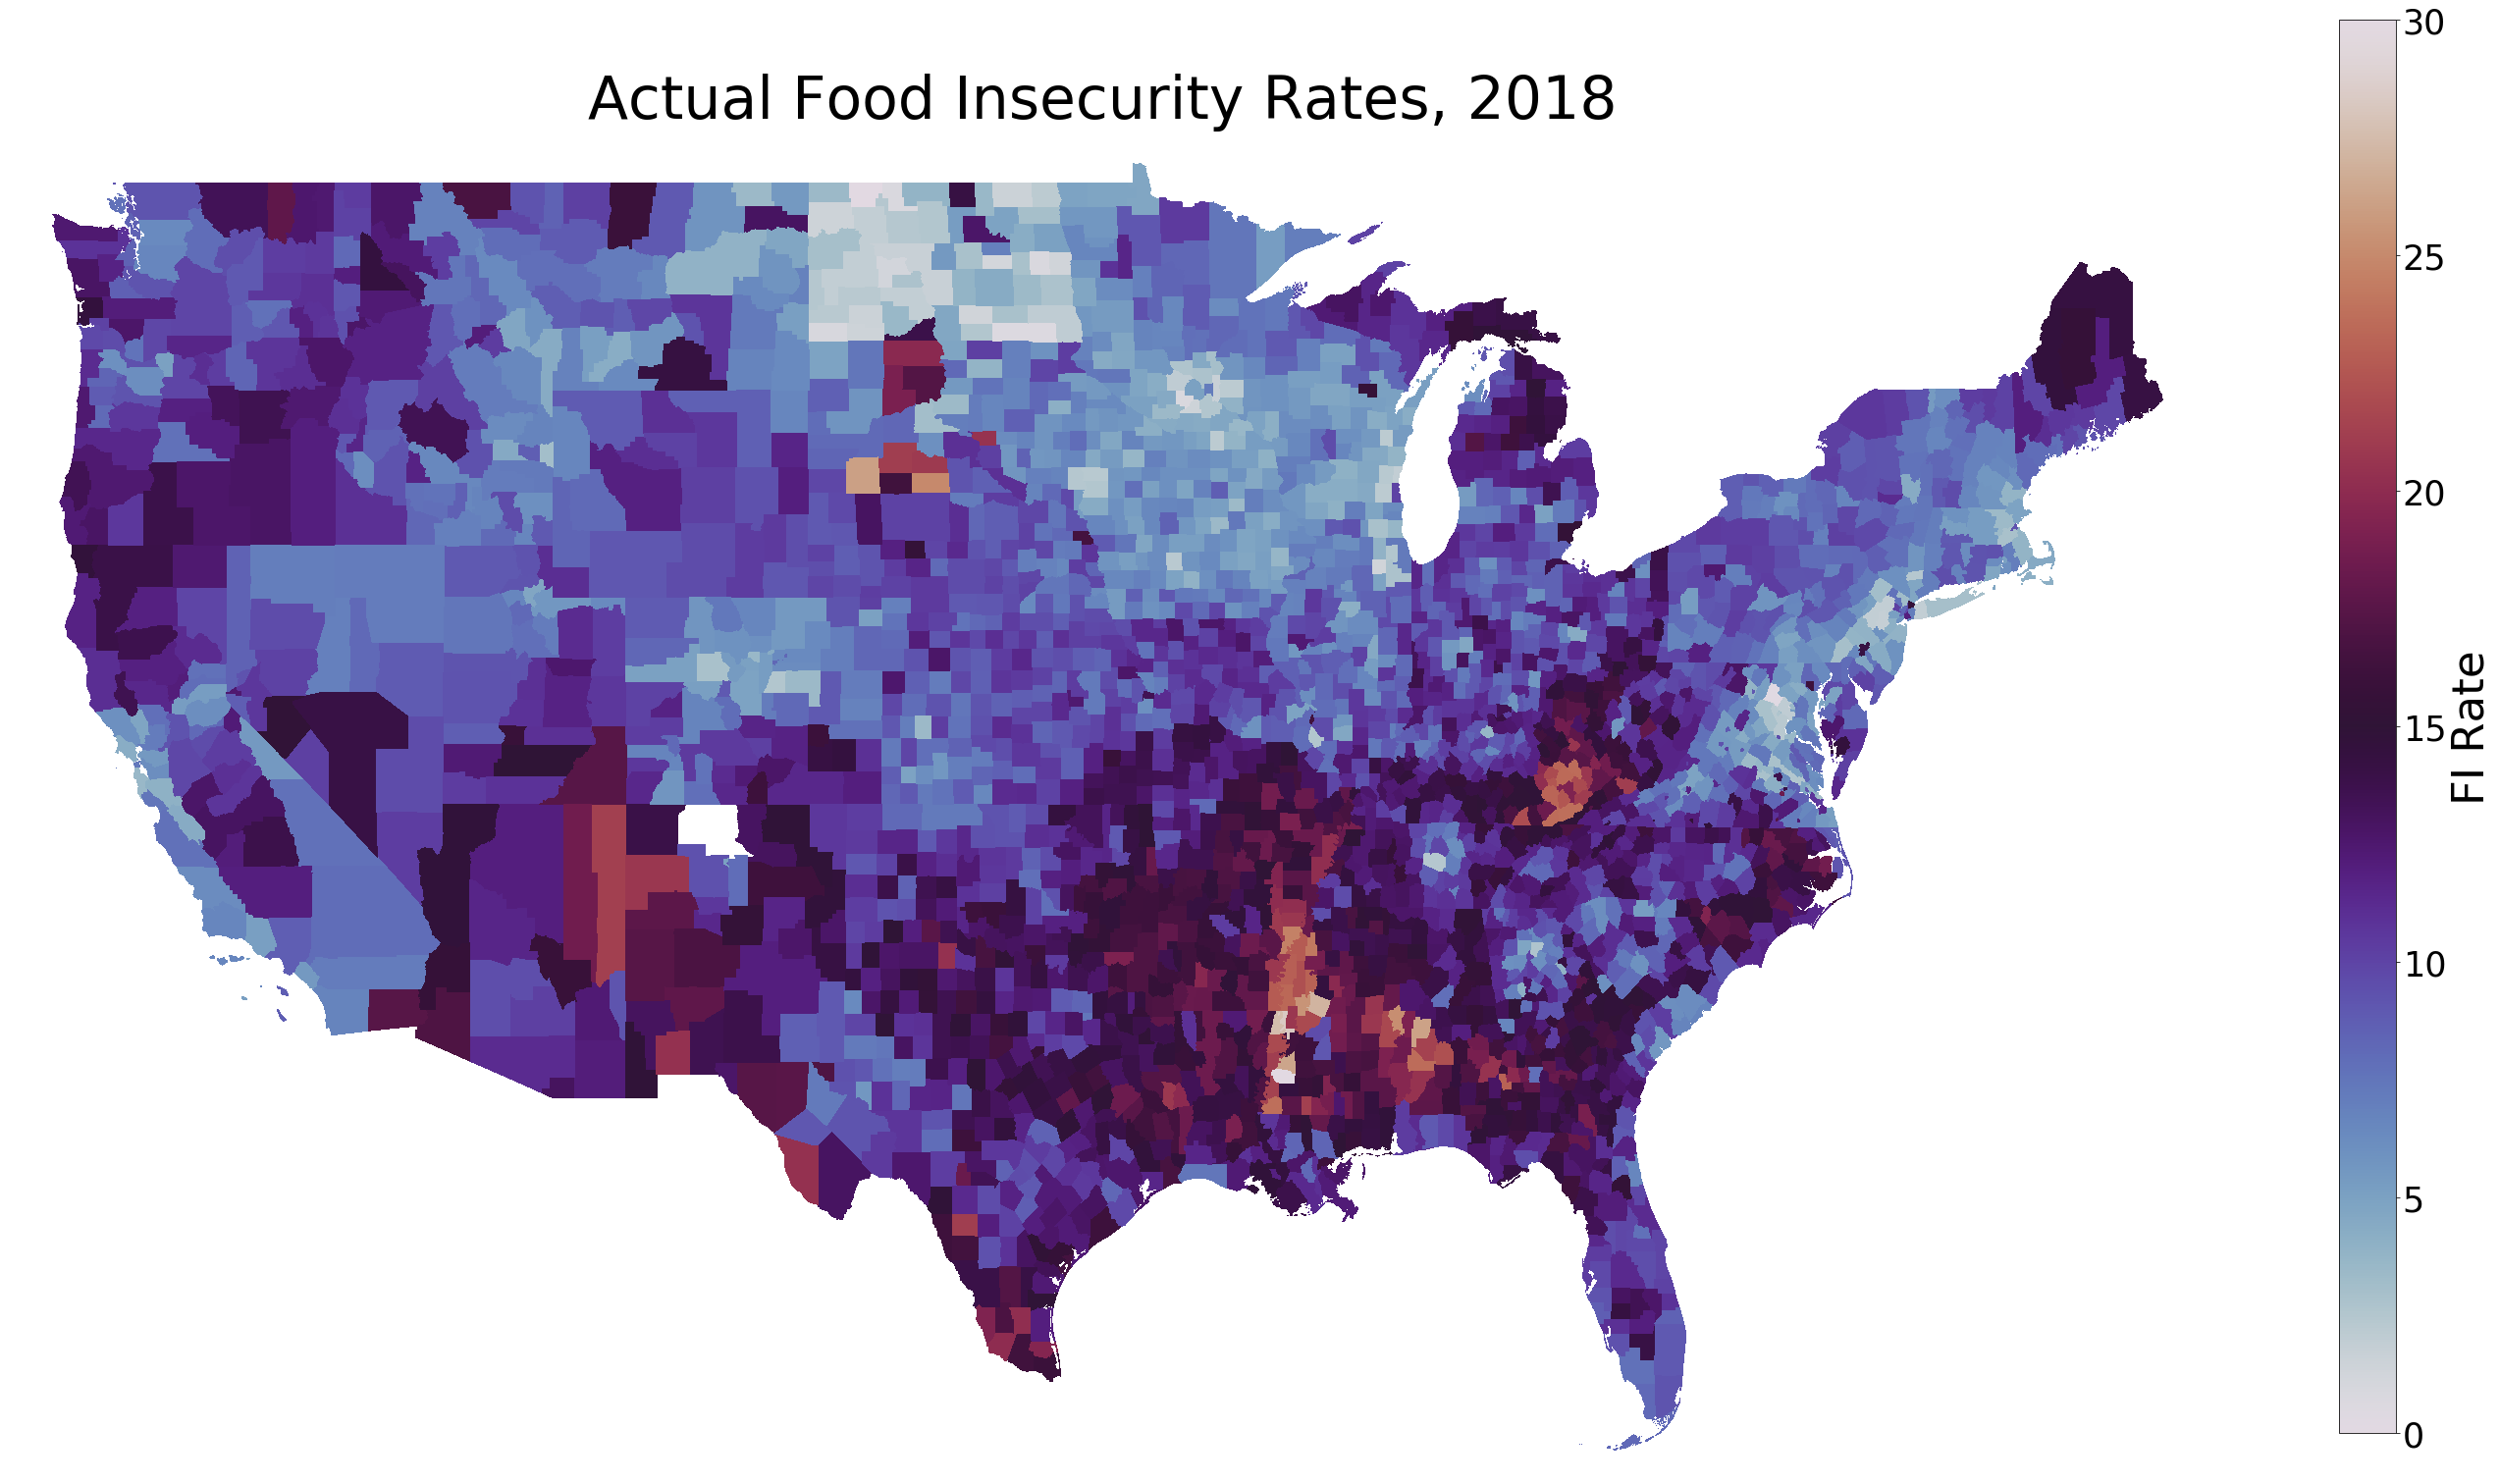

In [435]:
# linreg without polynomials, kept hs_grad rate
choropleth(df_preds_20,'Pred FI Rate 2020','2020','twilight','Model Predicted Food Insecurity Rates')
choropleth(df_preds_18,'Pred FI Rate 2018','2018','twilight','Model Predicted Food Insecurity Rates')
choropleth(df_18,'FI Rate','2018','twilight', 'Actual Food Insecurity Rates')

In [721]:
# neural net without polynomials - this did not work out lol


In [679]:
# linreg without polynomials, kept hs_grad rate, included 2020 houseless - too many nulls


In [680]:
# random forest with polynomials, with hs grad, added 2020 houseless - too many nulls


In [ ]:
# random forest with polynomials, no hs grad - not severe enough on 2018 preds


In [596]:
# linreg without polynomials, removed hs_grad rate - 2020 pred too dark blue


In [595]:
# linreg with polynomials and hs_grad, included 2020 houseless estimates - all red, need to remove polynomials


In [594]:
# linreg with polynomial features and hs grad - very bad, all red


### Feeding America 2020 Projections

In [464]:
with open('../pickled/projection_20.pickle', "rb") as input_file:
    df_projected = pickle.load(input_file) 
df_projected

,FIPS,Total Population,FI Rate,Year
0,01001,55200,0.186,2020
1,01003,208107,0.163,2020
2,01005,25782,0.251,2020
3,01007,22527,0.189,2020
4,01009,57645,0.161,2020
...,...,...,...,...
3137,56037,44117,0.150,2020
3138,56039,23059,0.135,2020
3139,56041,20609,0.166,2020
3140,56043,8129,0.152,2020


# Conclusion
The final RFE Model 5 was able to explain about 75% of the variance in the data, based on a cross validation R2 score of 0.7486, and was off on predictions by an average of 2%, based on Test RMSE score of 0.0198. The most important features used in this model were shown to be `Unsheltered_rate_X_Percent_asian`, `Sheltered_rate_X_Percent_white`, `Sheltered_rate_X_Percent_Black`, `Houseless_rate_X_Percent_asian`, and `Unsheltered_rate_X_Percent_male`, based on model coefficients. 
<br>**This indicates that both houselessness and race play a critical role in determining the likelihood of food insecurity, but especially so when these features interact** (ie. someone who is both Black and houseless.)<br>  

The choropleth maps on 2018 FI Rate predictions indicate that the model was able to capture the general trend of food insecurity, particularly in places that are most impacted.

### Next Steps
There is a lot of room to improve the model's ability to explain even more variance in the data, potentially by adding more features such as household income, food assistance programs, age, disability, eviction data, and transportation access.<br><br>
**The next iteration of this project aims to accomplish the following:**
- include more features
- utilize statistical testing during EDA
- employ different types of regression models
- create an interactive map to visualize features and trends
- project FI rates on unlabeled data from 2020